<a href="https://colab.research.google.com/github/galdir/Vibration_classification_dataset_Wonho_Jung/blob/main/Vibration_classification_dataset_Wonho_Jung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset source

Dataset from https://data.mendeley.com/datasets/ztmf3m7h5x


# Config

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import gc  

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


import scipy.io

from scipy import integrate
from scipy.signal import butter,filtfilt
from sklearn.utils import class_weight

import math
import pdb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold






In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/datasets/vibration fault diagnosis of rotating machine - Wonho Jung/vibration.zip'
model_path = '/content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models'

# zip file handler  
zip_handler = zipfile.ZipFile(dataset_path)

# list available files in the container
print (zip_handler.namelist())

['0Nm_BPFI_03.mat', '0Nm_BPFI_10.mat', '0Nm_BPFI_30.mat', '0Nm_BPFO_03.mat', '0Nm_BPFO_10.mat', '0Nm_BPFO_30.mat', '0Nm_Misalign_01.mat', '0Nm_Misalign_03.mat', '0Nm_Misalign_05.mat', '0Nm_Normal.mat', '0Nm_Unbalance_0583mg.mat', '0Nm_Unbalance_1169mg.mat', '0Nm_Unbalance_1751mg.mat', '0Nm_Unbalance_2239mg.mat', '0Nm_Unbalance_3318mg.mat', '2Nm_BPFI_03.mat', '2Nm_BPFI_10.mat', '2Nm_BPFI_30.mat', '2Nm_BPFO_03.mat', '2Nm_BPFO_10.mat', '2Nm_BPFO_30.mat', '2Nm_Misalign_01.mat', '2Nm_Misalign_03.mat', '2Nm_Misalign_05.mat', '2Nm_Normal.mat', '2Nm_Unbalalnce_0583mg.mat', '2Nm_Unbalalnce_1169mg.mat', '2Nm_Unbalalnce_1751mg.mat', '2Nm_Unbalalnce_2239mg.mat', '2Nm_Unbalalnce_3318mg.mat', '4Nm_BPFI_03.mat', '4Nm_BPFI_10.mat', '4Nm_BPFI_30.mat', '4Nm_BPFO_03.mat', '4Nm_BPFO_10.mat', '4Nm_BPFO_30.mat', '4Nm_Misalign_01.mat', '4Nm_Misalign_03.mat', '4Nm_Misalign_05.mat', '4Nm_Normal.mat', '4Nm_Unbalance_0583mg.mat', '4Nm_Unbalance_1169mg.mat', '4Nm_Unbalance_1751mg.mat', '4Nm_Unbalance_2239mg.mat',

In [4]:
files = zip_handler.namelist()

In [5]:
len(files)

45

## Utility functions

In [6]:
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data)
    return y

In [7]:
def acc_to_vel(data, fs):
  window_length = len(data)
  data = data - np.mean(data)
  time_length = (window_length)/fs
  time = np.linspace(0, time_length, int(fs * time_length))
  signal_integrated = integrate.cumtrapz(data, x=time, initial=0.0)
  #signal_integrated = signal_integrated[fs:]
  # Filter requirements.
  #T = 5.0         # Sample Period
  #fs = 30.0       # sample rate, Hz
  cutoff = 10      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
  order = 2
  signal_integrated = butter_lowpass_filter(signal_integrated, cutoff, fs, order)
  return signal_integrated


In [8]:
def signalAmpSpectrum(signal, window_length, fs):
  """
  A function that returns the amplitude spectrum of a signal. 
  Use numpy's fft, removing the redundancy and multiplying the remaining energy by two, as the energy was divided by two in the spectral redundancy.

  Parameters:
    signal : array_like
      Input array
    window_length : int
      Number of points in the input to use. 
      Signal is reduced to the window_length.
    fs : int
      Sample frequency of the signal to calculate frequency array.  
  """
  
  #pdb.set_trace()
  signal = signal[:window_length]
  amps = np.abs(np.fft.rfft(signal))/window_length
  amps[0] = 0
  amps = amps * 2
  
  freqs = np.fft.rfftfreq(window_length, 1/fs)
  return [freqs, amps]

In [9]:
help(signalAmpSpectrum)

Help on function signalAmpSpectrum in module __main__:

signalAmpSpectrum(signal, window_length, fs)
    A function that returns the amplitude spectrum of a signal. 
    Use numpy's fft, removing the redundancy and multiplying the remaining energy by two, as the energy was divided by two in the spectral redundancy.
    
    Parameters:
      signal : array_like
        Input array
      window_length : int
        Number of points in the input to use. 
        Signal is reduced to the window_length.
      fs : int
        Sample frequency of the signal to calculate frequency array.



In [11]:
def plot_channels_time(experiment):
  print(data_names[experiment])

  window_length = len(data[experiment]['channel_1'])
  #data = data - np.mean(data)
  time_length = (window_length)/fs
  time = np.linspace(0, time_length, int(fs * time_length))

  fig = plt.figure(figsize=(12,8))
  ax1=plt.subplot(2,2,1)
  ax1.plot(time, data[experiment]['channel_1'])

  ax2=plt.subplot(2,2,2, sharey=ax1)
  ax2.plot(time, data[experiment]['channel_2'])

  ax3=plt.subplot(2,2,3, sharey=ax1)
  ax3.plot(time, data[experiment]['channel_3'])

  ax4=plt.subplot(2,2,4, sharey=ax1)
  ax4.plot(time, data[experiment]['channel_4'])

  plt.tight_layout()
  #fig.savefig("../figures/Fig.4_cd.png", dpi=200)
  plt.show()
  fig.clf()
  plt.close()
  gc.collect()


In [12]:
def plot_channels_spectra(experiment, y_lim=0, x_lim=600):
  print(data_names[experiment])
  fig = plt.figure(figsize=(12,8))
  ax1=plt.subplot(2,2,1)
  window_length = int(fs)
  starting_index = fs
  amp = np.abs(np.fft.rfft(data[experiment]['channel_1'].loc[starting_index : window_length + starting_index]))/window_length
  amp[0]=0
  amp=amp*2
  freq = np.fft.rfftfreq(window_length, d=1/fs)
  ax1.plot(freq, amp)
  amp_max = np.max(amp)

  #ax2=plt.subplot(2,2,2, sharey=ax1)
  ax2=plt.subplot(2, 2, 2)
  amp = np.abs(np.fft.rfft(data[experiment]['channel_2'].loc[starting_index : starting_index + window_length]))/window_length
  amp[0]=0 
  amp=amp*2
  freq = np.fft.rfftfreq(window_length, d=1/fs)
  ax2.plot(freq, amp)
  amp_max = max(np.max(amp), amp_max)

  #ax3=plt.subplot(2, 2, 3, sharey=ax1)
  ax3=plt.subplot(2, 2, 3)
  amp = np.abs(np.fft.rfft(data[experiment]['channel_3'].loc[starting_index : starting_index + window_length]))/window_length
  amp[0]=0 
  amp=amp*2
  freq = np.fft.rfftfreq(window_length, d=1/fs)
  ax3.plot(freq, amp)
  amp_max = max(np.max(amp), amp_max)

  #ax4=plt.subplot(2, 2, 4, sharey=ax1)
  ax4=plt.subplot(2, 2, 4)
  amp = np.abs(np.fft.rfft(data[experiment]['channel_4'].loc[starting_index : starting_index + window_length]))/window_length
  amp[0]=0 
  amp=amp*2
  freq = np.fft.rfftfreq(window_length, d=1/fs)
  ax4.plot(freq, amp)
  if y_lim == 0:
    amp_max = max(np.max(amp), amp_max*1.1)
  else:
    amp_max = y_lim
  
  print(amp_max)
  ax1.set_ylim((0, amp_max))
  ax2.set_ylim((0, amp_max))
  ax3.set_ylim((0, amp_max))
  ax4.set_ylim((0, amp_max))
  ax1.set_xlim((0, x_lim))
  ax2.set_xlim((0, x_lim))
  ax3.set_xlim((0, x_lim))
  ax4.set_xlim((0, x_lim))


  plt.tight_layout()
  #fig.savefig("../figures/Fig.4_cd.png", dpi=200)
  plt.show()
  fig.clf()
  plt.close()
  gc.collect()

# Loading, converting acc to vel and downsampling

In [ ]:
fs=25600
new_fs = 4096
def mat_dataset_to_df(mat):
  datadf = [item.flat[0] for item in mat['Signal'][0][0]['y_values']['values']]
  a = datadf[0][:,0]
  #print(len(a))
  b = datadf[0][:,1]
  c = datadf[0][:,2]
  d = datadf[0][:,3]
  secs = len(a)/fs # Number of seconds in signal X
  samps = int(secs * new_fs)     # Number of samples to downsample
  a = scipy.signal.resample(a, samps)
  #print(len(a))
  b = scipy.signal.resample(b, samps)
  c = scipy.signal.resample(c, samps)
  d = scipy.signal.resample(d, samps)

  #a = acc_to_vel(a, new_fs)
  #b = acc_to_vel(b, new_fs)
  #c = acc_to_vel(c, new_fs)
  #d = acc_to_vel(d, new_fs)

  #print(len(datadf))
  columns = ['channel_1', 'channel_2', 'channel_3', 'channel_4' ]
  df = pd.DataFrame(list(zip(a, b, c, d)), columns=columns)  
  df.reset_index(inplace=True, drop=True)
  df.loc[:, 'channel_1']=acc_to_vel(df['channel_1'].values, new_fs)
  df.loc[:, 'channel_2']=acc_to_vel(df['channel_2'].values, new_fs)
  df.loc[:, 'channel_3']=acc_to_vel(df['channel_3'].values, new_fs)
  df.loc[:, 'channel_4']=acc_to_vel(df['channel_4'].values, new_fs)
  return df


data = []
data_names = []
with zipfile.ZipFile(url, 'r') as f:
  for i in range(len(files)):
    tokens = files[i].split('_')
    if(not tokens[1].startswith('BPF')):
      print(files[i])
      with f.open(files[i], 'r') as c:
          mat = scipy.io.loadmat(c)
          df = mat_dataset_to_df(mat)
          data.append(df)
          data_names.append(files[i])

0Nm_Misalign_01.mat
0Nm_Misalign_03.mat
0Nm_Misalign_05.mat
0Nm_Normal.mat
0Nm_Unbalance_0583mg.mat
0Nm_Unbalance_1169mg.mat
0Nm_Unbalance_1751mg.mat
0Nm_Unbalance_2239mg.mat
0Nm_Unbalance_3318mg.mat
2Nm_Misalign_01.mat
2Nm_Misalign_03.mat
2Nm_Misalign_05.mat
2Nm_Normal.mat
2Nm_Unbalalnce_0583mg.mat
2Nm_Unbalalnce_1169mg.mat
2Nm_Unbalalnce_1751mg.mat
2Nm_Unbalalnce_2239mg.mat
2Nm_Unbalalnce_3318mg.mat
4Nm_Misalign_01.mat
4Nm_Misalign_03.mat
4Nm_Misalign_05.mat
4Nm_Normal.mat
4Nm_Unbalance_0583mg.mat
4Nm_Unbalance_1169mg.mat
4Nm_Unbalance_1751mg.mat
4Nm_Unbalance_2239mg.mat
4Nm_Unbalance_3318mg.mat


In [ ]:
fs=new_fs
speed = 3010 #rpm
amostras_por_rotacao = 1 / (speed / 60) * fs

In [ ]:
experiment = 0

In [ ]:
data[experiment]

,channel_1,channel_2,channel_3,channel_4
0,-0.000037,0.000063,0.000107,0.000094
1,0.000118,0.000032,0.000051,0.000118
2,0.000164,0.000029,0.000033,0.000087
3,0.000037,0.000070,0.000059,0.000081
4,0.000055,0.000089,0.000062,0.000120
...,...,...,...,...
491515,-0.000114,0.000017,0.000012,-0.000047
491516,-0.000068,0.000038,-0.000046,-0.000055
491517,0.000021,-0.000043,-0.000081,-0.000028
491518,0.000034,-0.000014,-0.000016,-0.000034


## EDA

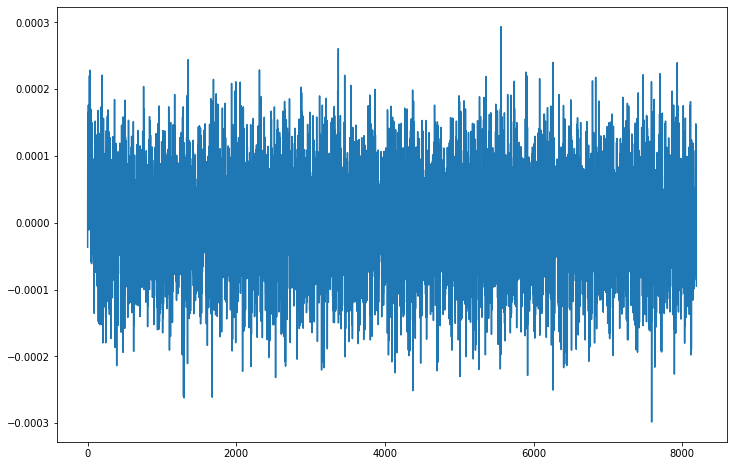

In [ ]:
experiment = 0
fig = plt.figure(figsize=(12,8))
data[experiment]['channel_1'][:fs+fs].plot()


In [ ]:
fig.clf()
plt.close()
gc.collect()

106

In [ ]:
fs

4096

0Nm_Misalign_01.mat


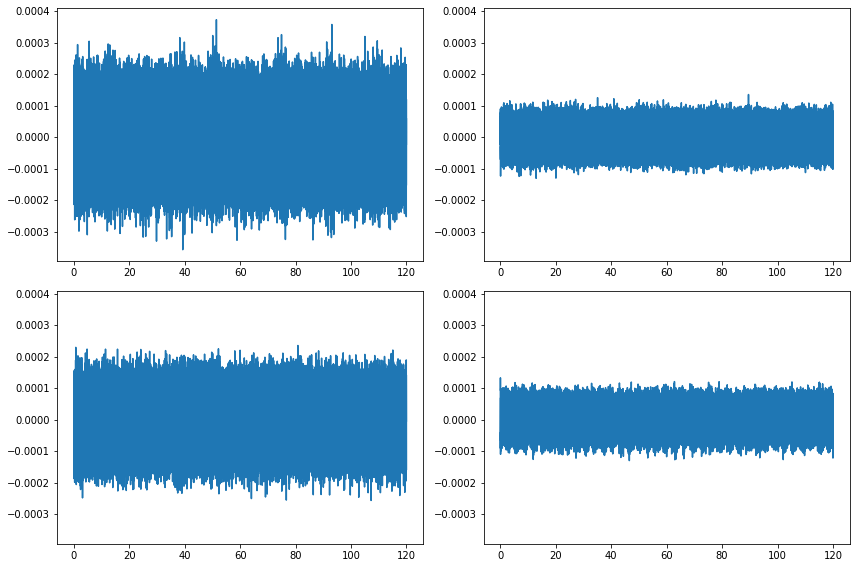

In [ ]:
plot_channels_time(0)

0Nm_Misalign_03.mat


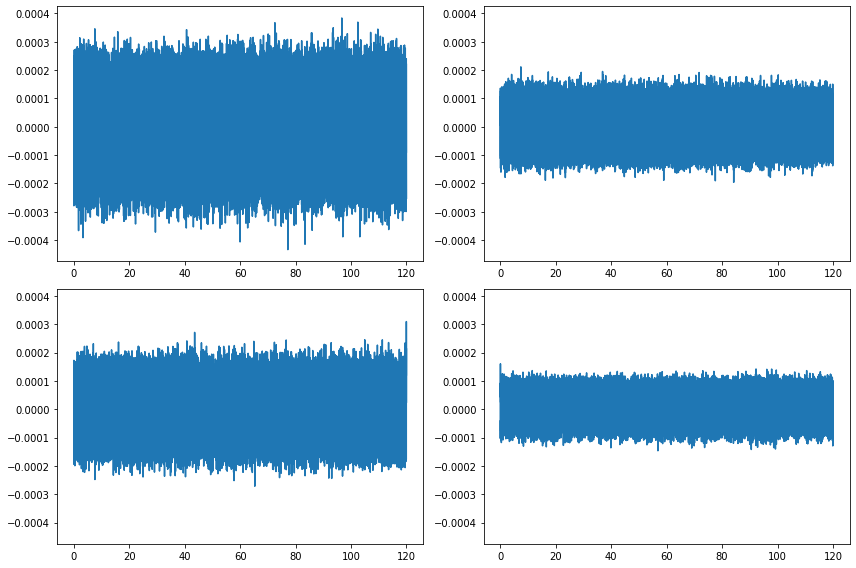

In [ ]:
plot_channels_time(1)

0Nm_Misalign_01.mat
0.0001


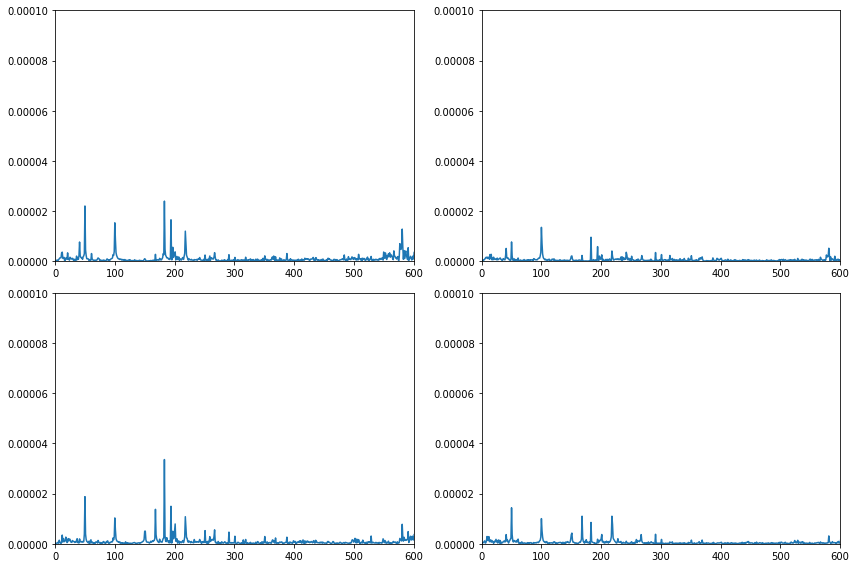

In [ ]:
plot_channels_spectra(0, y_lim=0.0001)

4Nm_Unbalance_3318mg.mat
0.0001


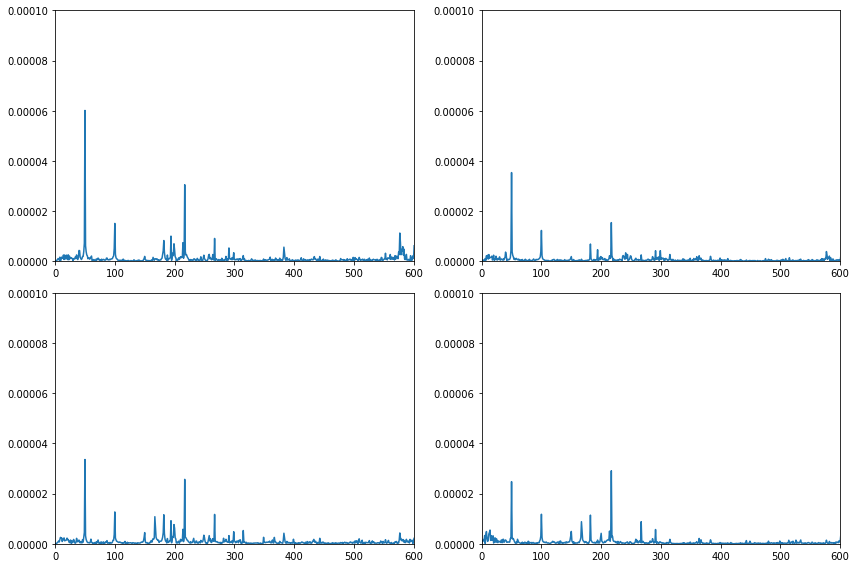

In [ ]:
plot_channels_spectra(26, y_lim=0.0001)

0Nm_Misalign_05.mat
0.0001


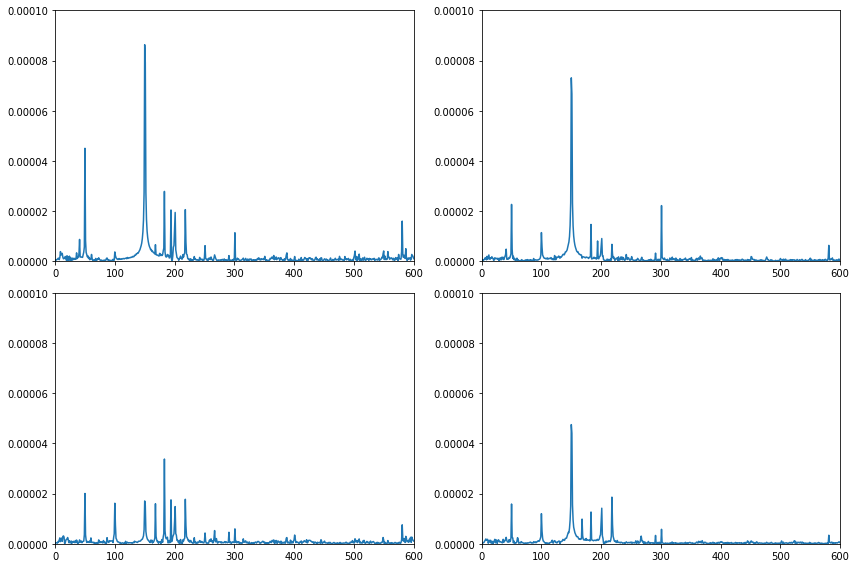

In [ ]:
plot_channels_spectra(2, y_lim=0.0001)

0Nm_Normal.mat
0.0001


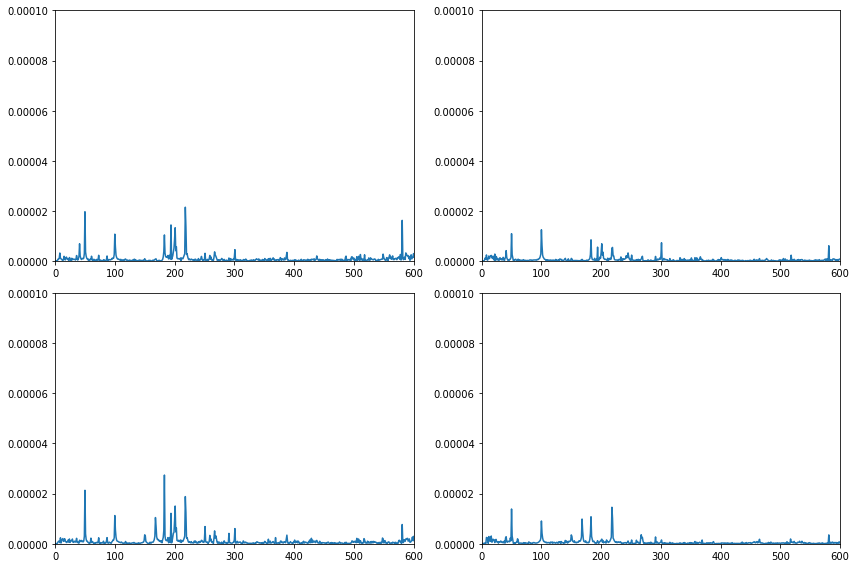

In [ ]:
plot_channels_spectra(3, y_lim=0.0001)

In [ ]:
data_names

['0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalance_1751mg.mat',
 '4Nm_Unbalance_2239mg.mat',
 '4Nm_Unbalance_3318mg.mat']

4Nm_Misalign_05.mat
6.0619395104900535e-05


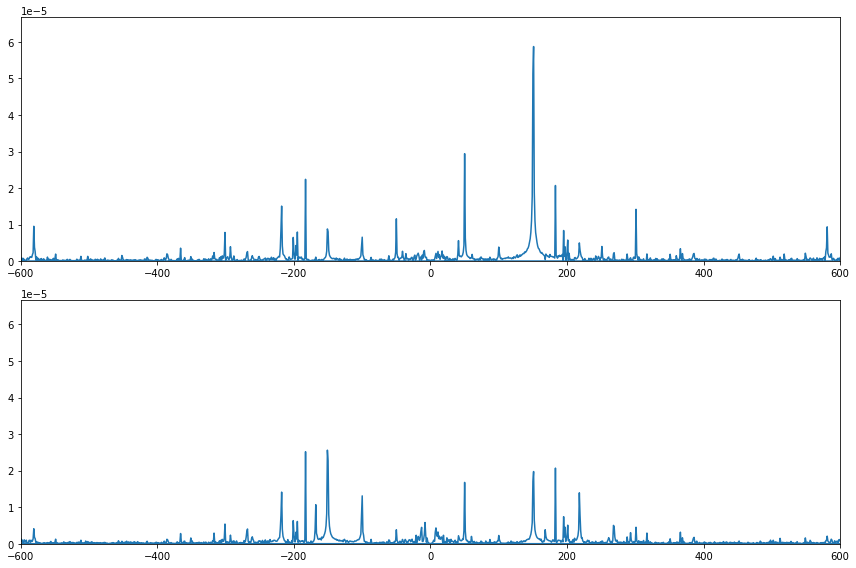

In [ ]:
plot_channels_fullspectra(20)

## Orbit

In [ ]:
fs

4096

In [ ]:
amostras_por_rotacao = (1 / (speed / 60)) * fs

In [ ]:
data[experiment]['channel_1'][:int(amostras_por_rotacao)]

0    -0.000037
1     0.000118
2     0.000164
3     0.000037
4     0.000055
        ...   
76    0.000093
77    0.000033
78   -0.000047
79    0.000067
80    0.000022
Name: channel_1, Length: 81, dtype: float64

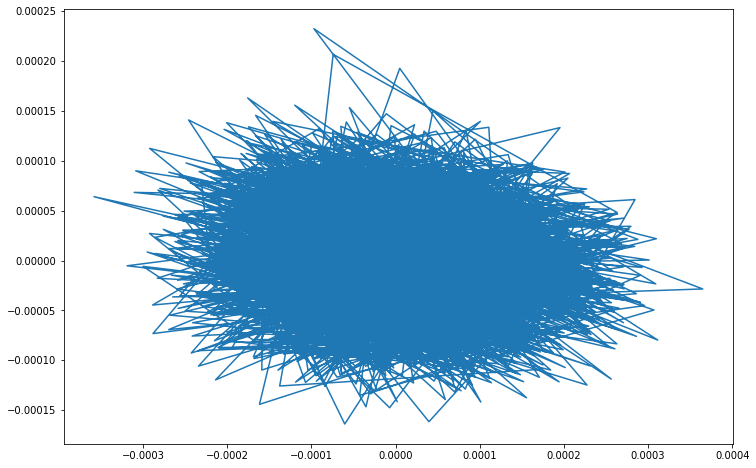

In [ ]:
experiment = 26
x = data[experiment]['channel_1'][ fs : fs + fs ].values
y = data[experiment]['channel_2'][ fs : fs + fs ].values
fig = plt.figure(figsize=(12,8))
plt.plot(x, y)

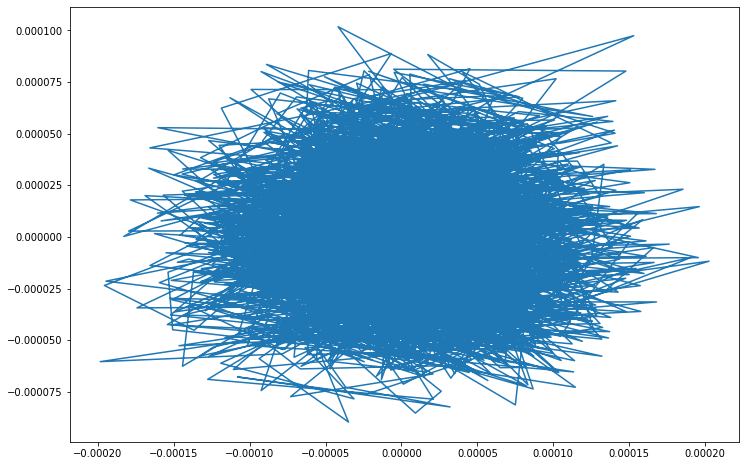

In [ ]:
experiment = 0
x = data[experiment]['channel_3'][ fs : fs + fs].values
y = data[experiment]['channel_4'][ fs : fs + fs].values
fig = plt.figure(figsize=(12,8))
plt.plot(x, y)

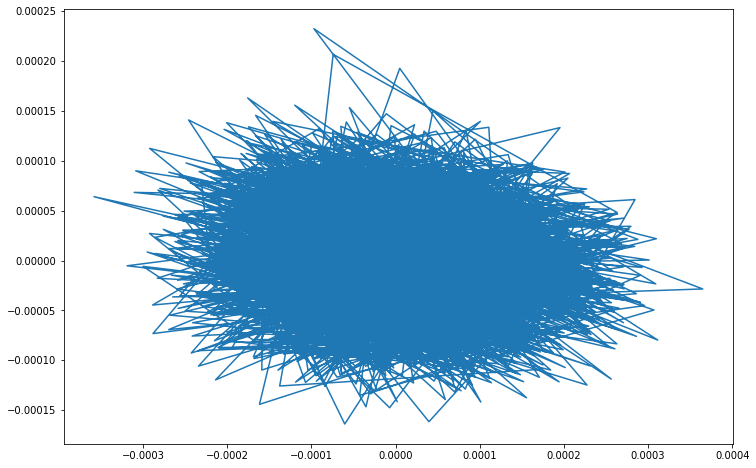

In [ ]:
experiment = 26
x = data[experiment]['channel_1'][fs : fs*2].values
y = data[experiment]['channel_2'][fs : fs*2].values
fig = plt.figure(figsize=(12,8))
plt.plot(x, y)

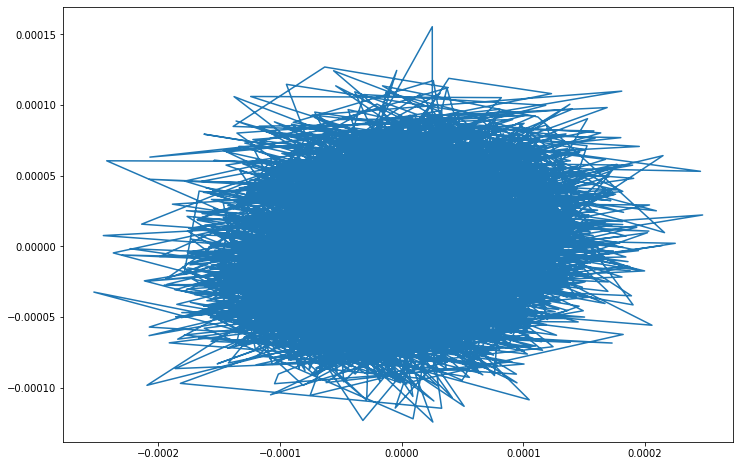

In [ ]:
experiment = 26
x = data[experiment]['channel_3'][fs : fs * 2].values
y = data[experiment]['channel_4'][fs : fs * 2].values
fig = plt.figure(figsize=(12,8))
plt.plot(x, y)

In [ ]:
fig.clf()
plt.close()
gc.collect()

3279

## Cross correlation to understand the relations between channels

In [ ]:
experiment = 0

In [ ]:
fs

4096

In [ ]:
data[experiment]['channel_1'][fs*10:fs*12]

40960    0.000073
40961   -0.000009
40962    0.000017
40963   -0.000058
40964   -0.000043
           ...   
49147    0.000064
49148   -0.000072
49149   -0.000043
49150    0.000034
49151   -0.000128
Name: channel_1, Length: 8192, dtype: float64

(array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
        -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50]),
 array([ 0.01706372, -0.10935289, -0.03848459,  0.07908107, -0.0578873 ,
         0.04502594,  0.06611615, -0.12468448,  0.01989879,  0.05981564,
        -0.04299407,  0.07596198, -0.08574828, -0.20156469,  0.02071226,
        -0.10821585, -0.17821404, -0.07286175, -0.27281421, -0.12940435,
         0.05963941, -0.20958822, -0.13551241, -0.03147137, -0.15310883,
         0.1044884 ,  0.1159153 , -0.0334034 ,  0.20481726,  0.0

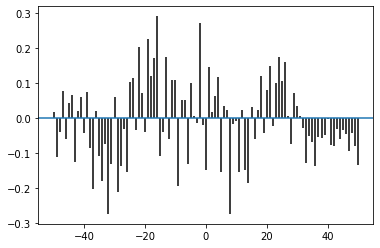

In [ ]:
plt.xcorr(data[experiment]['channel_1'][fs*10:fs*12],data[experiment]['channel_2'][fs*10:fs*12], maxlags=50)

(array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
        -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50]),
 array([ 1.04585787e-01, -3.60321017e-02, -1.11989768e-01,  2.26605410e-01,
        -2.86975766e-02, -4.85959650e-02,  2.66717285e-01,  8.41545335e-03,
         1.30194919e-01,  2.85509411e-01, -1.17058020e-01,  1.25797145e-01,
         2.00301530e-01, -1.61710981e-01,  1.81120047e-01,  6.99395131e-02,
        -2.23561629e-01,  1.83347103e-01, -9.13427471e-02, -2.46342636e-01,
         2.06483634e-01, -1.23870161e-01, -5.1481

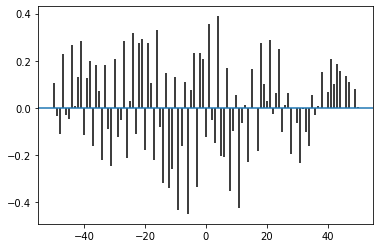

In [ ]:
plt.xcorr(data[experiment]['channel_1'][fs*10:fs*12],data[experiment]['channel_3'][fs*10:fs*12], maxlags=50)

(array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
        -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50]),
 array([ 0.03710548,  0.07132569, -0.02715147, -0.03943338, -0.1025328 ,
        -0.14642228,  0.01336174, -0.0384263 , -0.18177801, -0.127623  ,
        -0.15171908, -0.10497489, -0.00363613, -0.14829848, -0.16151894,
        -0.05149455, -0.14913559, -0.14496005, -0.11304418, -0.15952462,
        -0.06568455, -0.1198819 , -0.22394507, -0.12391262, -0.09578728,
        -0.0741012 , -0.07343597, -0.19025277, -0.05701241,  0.1

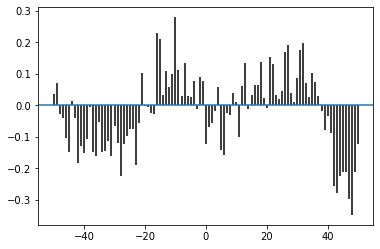

In [ ]:
plt.xcorr(data[experiment]['channel_2'][fs*10:fs*12],data[experiment]['channel_4'][fs*10:fs*12], maxlags=50)

(array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
        -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50]),
 array([-0.01378112, -0.129984  , -0.1791309 ,  0.097577  ,  0.01393655,
        -0.08124735,  0.04855628, -0.03632852,  0.12033217,  0.3026354 ,
         0.08973623,  0.15834244,  0.24156314,  0.12270653,  0.28806722,
         0.20701834,  0.0221749 ,  0.20651769,  0.10041796, -0.02442496,
         0.09105038, -0.10347734, -0.06197565,  0.10174777, -0.1335656 ,
        -0.06196652,  0.03061764, -0.10382213,  0.11045216,  0.0

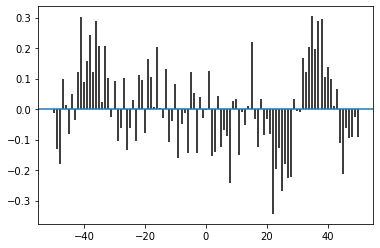

In [ ]:
plt.xcorr(data[experiment]['channel_3'][fs*10:fs*12],data[experiment]['channel_4'][fs*10:fs*12], maxlags=50)

(array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
        -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50]),
 array([-1.23637906e-01, -5.61573595e-02,  2.57941377e-02, -2.63408261e-02,
         6.90204565e-03, -1.87169880e-02, -8.18818367e-02,  1.09161695e-01,
         1.19451073e-01, -8.03989642e-03,  1.06805021e-01, -1.52139283e-02,
        -1.05684143e-01,  1.05009776e-01, -5.82098894e-02, -9.27532118e-02,
         1.02908656e-01, -1.78091684e-01, -1.68021575e-01, -6.03493718e-04,
        -2.66195943e-01, -3.94616558e-02,  1.2628

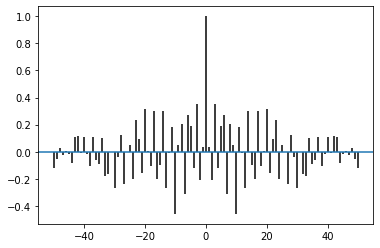

In [ ]:
plt.xcorr(data[experiment]['channel_1'][fs*10:fs*12],data[experiment]['channel_1'][fs*10:fs*12], maxlags=50)

# Classification of 3 classes

## Preprocessing

In [ ]:
len(data_names)

27

In [ ]:
data_names

['0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalance_1751mg.mat',
 '4Nm_Unbalance_2239mg.mat',
 '4Nm_Unbalance_3318mg.mat']

In [ ]:
labels = []
labels_dic = {'Misalign':2, 'Normal.mat': 0, 'Unbalance': 1, 'Unbalalnce': 1}

for name in data_names:
  tokens = name.split('_')
  print(tokens[1])
  labels.append(labels_dic.get(tokens[1], "No info available"))

print(f'Labels: {labels}')
print(len(labels))
  

Misalign
Misalign
Misalign
Normal.mat
Unbalance
Unbalance
Unbalance
Unbalance
Unbalance
Misalign
Misalign
Misalign
Normal.mat
Unbalalnce
Unbalalnce
Unbalalnce
Unbalalnce
Unbalalnce
Misalign
Misalign
Misalign
Normal.mat
Unbalance
Unbalance
Unbalance
Unbalance
Unbalance
Labels: [2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1]
27


In [ ]:
fs

4096

In [ ]:
print(labels.count(0)/len(labels))
print(labels.count(1)/len(labels))
print(labels.count(2)/len(labels))

0.1111111111111111
0.5555555555555556
0.3333333333333333


In [ ]:
def get_features(data, label, window):
    #data = data[fs:] #removing samples to avoid integration anomaly
    n = int(np.floor(len(data)/window))
    #print(len(data)/window)
    #print(n)
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))

    #X = np.abs(np.fft.rfft(X))/window
    #X[:,0]=0
    #X = X * 2
    #X=X[:, 0:600] # reducing to max 600Hz
    
    y = np.ones(n)*label
    return X, y




In [ ]:
sensor = 'channel_1'
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


X0,y0 = get_features(data[0][sensor], labels[0], window)
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features(data[i][sensor], labels[i], window)
  X0=np.concatenate([X0, X1])
  y0=np.concatenate([y0, y1])

X = X0
y = y0

print(X.shape, y.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
(3420, 4096) (3420,)


In [ ]:
sensor = 'channel_2'
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


X0,y0 = get_features(data[0][sensor], labels[0], window)
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features(data[i][sensor], labels[i], window)
  X0=np.concatenate([X0, X1])

X2 = X0


print(X2.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
(3420, 4096)


In [ ]:
print(len(y[y==0])/len(y))
print(len(y[y==1])/len(y))
print(len(y[y==2])/len(y))

0.15789473684210525
0.5263157894736842
0.3157894736842105


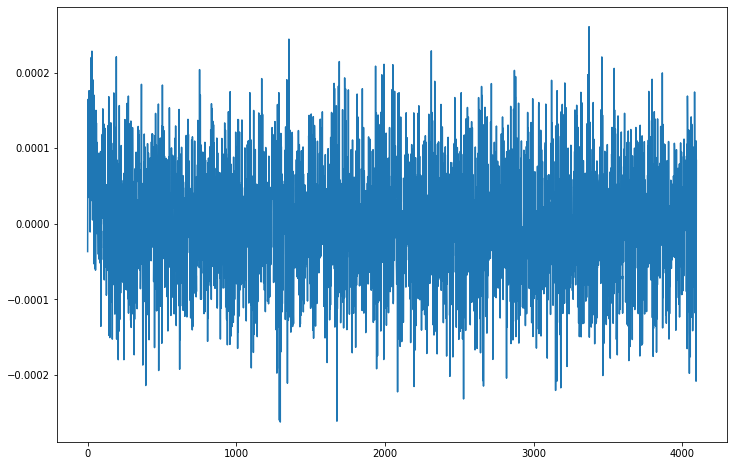

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X[0])

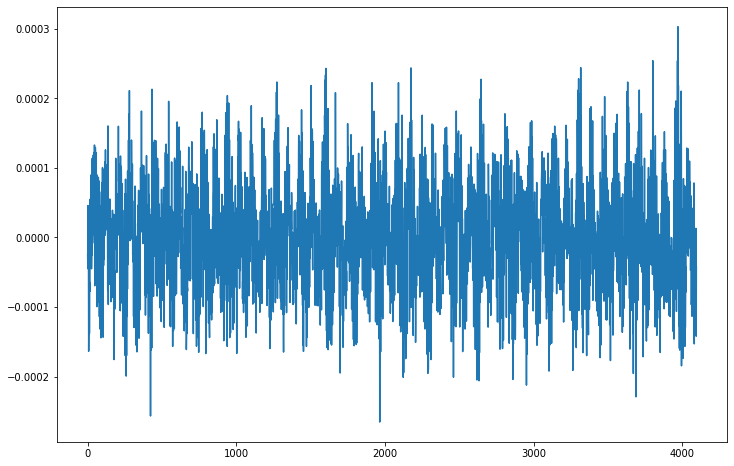

In [ ]:
fig = plt.figure(figsize=(12,8))

plt.plot(X[1000])

## Split

In [ ]:
train_test_ratio = 0.8
X_train, X_test, y_train, y_test, X2_train, X2_test = train_test_split(X, y, X2, test_size = 1-train_test_ratio, random_state = 42)

print(X.shape, y.shape, X2.shape)

print(X_train.shape, y_train.shape, X2_train.shape)


(3420, 4096) (3420,) (3420, 4096)
(2736, 4096) (2736,) (2736, 4096)


In [ ]:
n_classes = 3
weight_for_0 = len(y_train)/(n_classes *len(y_train[y_train==0]))
weight_for_1 = len(y_train)/(n_classes *len(y_train[y_train==1]))
weight_for_2 = len(y_train)/(n_classes *len(y_train[y_train==2]))
class_weights_dict = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

In [ ]:
class_weights_dict

{0: 2.161137440758294, 1: 0.6174678402166554, 2: 1.0896057347670252}

In [ ]:
len(y[y==0])/len(y)

0.15789473684210525

In [ ]:
len(y_train[y_train==0])/len(y_train)

0.15423976608187134

In [ ]:
len(y[y==1])/len(y)

0.5263157894736842

In [ ]:
len(y_train[y_train==1])/len(y_train)

0.5398391812865497

In [ ]:
len(y[y==2])/len(y)

0.3157894736842105

In [ ]:
len(y_train[y_train==2])/len(y_train)

0.3059210526315789

## fft of one channel

### Preprocessing

In [ ]:

window = X_train.shape[1] 
X_train_prepared = np.abs(np.fft.rfft(X_train))/window
X_train_prepared[:, 0]=0
X_train_prepared = X_train_prepared * 2
X_train_prepared = X_train_prepared[:, 0:600] # reducing to max 600Hz

#caler = MinMaxScaler()
#scaler.fit(X_train_prepared)
#X_train_scaled = scaler.transform(X_train_prepared)
#X_train_prepared = X_train_scaled

X_train_prepared = X_train_prepared * 10000




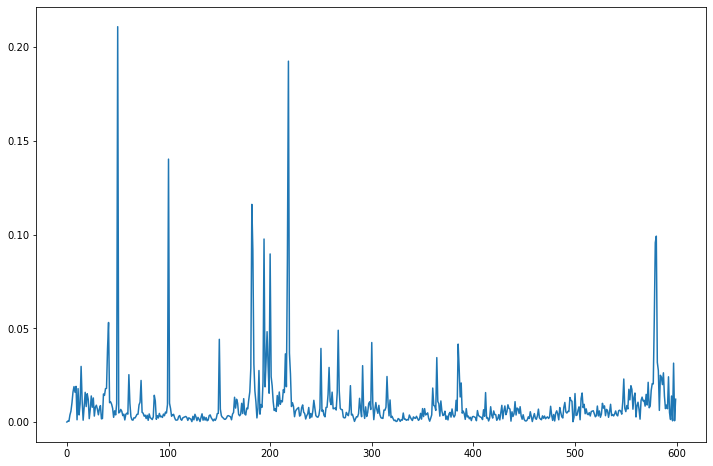

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X_train_prepared[0])

### Training

In [ ]:

#X_train_prepared = np.reshape(X_train_prepared, (X_train_prepared.shape[0], X_train_prepared.shape[1], 1))


In [ ]:
def basicModel(X_train):
  kernel_size = 10
  filter_size = 32

  model = models.Sequential()
  model.add(layers.Conv1D(filters=32, kernel_size=10, activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Conv1D(filter_size, (3), activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  #model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(n_classes, activation = 'softmax'))
  return model

In [ ]:
model = basicModel(X_train_prepared)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 591, 32)           352       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 295, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 286, 32)           10272     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 143, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 134, 32)           10272     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 67, 32)          

In [ ]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
best_model_filepath = f"{model_path}/cnn_base_line.h5"
checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')

In [ ]:
n_epochs = 20
history = model.fit(X_train_prepared, y_train, epochs = n_epochs, batch_size = 64,
                   validation_split=0.33, callbacks=[checkpoint],
                    class_weight=class_weights_dict)

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 0.6996 - accuracy: 0.8161
Epoch 1: val_accuracy improved from -inf to 0.83721, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line.h5
29/29 [==============================] - 5s 135ms/step - loss: 0.6996 - accuracy: 0.8161 - val_loss: 0.3381 - val_accuracy: 0.8372
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9209
Epoch 2: val_accuracy improved from 0.83721 to 0.86157, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line.h5
29/29 [==============================] - 5s 184ms/step - loss: 0.2215 - accuracy: 0.9209 - val_loss: 0.3477 - val_accuracy: 0.8616
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9444
Epoch 3: val_accuracy improved from 0.86157 to 0.97231, saving model to /content/drive/MyDrive/Vibratio

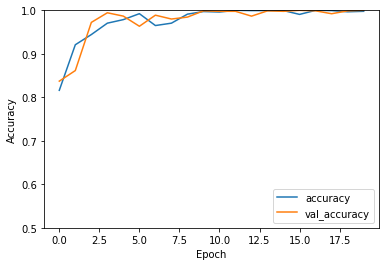

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### evaluation

In [ ]:
X_test_prepared = np.abs(np.fft.rfft(X_test))/window
X_test_prepared[:, 0]=0
X_test_prepared = X_test_prepared * 2
X_test_prepared = X_test_prepared[:, 0:600] # reducing to max 600Hz

#X_test_prepared = scaler.transform(X_test_prepared)

X_test_prepared = X_test_prepared * 10000


#X_test_prepared = np.reshape(X_test_prepared, (X_test_prepared.shape[0], X_test_prepared.shape[1], 1))

In [ ]:
best_model = load_model(best_model_filepath)
best_model.evaluate(X_test_prepared, y_test)

22/22 [==============================] - 1s 17ms/step - loss: 0.0030 - accuracy: 1.0000


[0.002998282667249441, 1.0]

In [ ]:
y_pred = best_model.predict(X_test_prepared)


22/22 [==============================] - 0s 17ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_matrix(y_test, y_pred_classes)



array([[118,   0,   0],
       [  0, 323,   0],
       [  0,   0, 243]])

In [ ]:

prec = precision_score(y_test, y_pred_classes, average='macro' )
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Precision: {prec}') 
print(f'Recall: {recall}') 
print(f'F1-score: {f1}')

Precision: 1.0
Recall: 1.0
F1-score: 1.0


### cross validation

In [ ]:

num_folds = 5
acc_per_fold = []
loss_per_fold = []
batch_size = 64
no_epochs = 20
verbosity = 1

window = X_train.shape[1] 
X_prepared = np.abs(np.fft.rfft(X))/window
X_prepared[:, 0]=0
X_prepared = X_prepared * 2
X_prepared = X_prepared[:, 0:600] # reducing to max 600Hz

#scaler = MinMaxScaler()
#scaler.fit(X_prepared)
#X_prepared = scaler.transform(X_prepared)

X_prepared = X_prepared * 10000

# Define the K-fold Cross Validator
skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skfold.split(X_prepared, y):

  # Define the model architecture
  model = basicModel(X_prepared[train])

  model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  best_model_filepath = f"{model_path}/cnn_base_line_cv_{fold_no}.h5"
  print(best_model_filepath)
  checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
  
  class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y[train]),
                                                 y = y[train])
  class_weights_dict = dict(enumerate(class_weights))

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(X_prepared[train], y[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              class_weight=class_weights_dict,
              validation_split=0.2, 
              callbacks=[checkpoint])
  
  model = load_model(best_model_filepath)
  
  # Generate generalization metrics
  scores = model.evaluate(X_prepared[test], y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

print(acc_per_fold)

/content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_cv_1.h5
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
34/35 [============================>.] - ETA: 0s - loss: 0.6922 - accuracy: 0.6907
Epoch 1: val_accuracy improved from -inf to 0.64234, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_cv_1.h5
35/35 [==============================] - 5s 136ms/step - loss: 0.6907 - accuracy: 0.6915 - val_loss: 1.2426 - val_accuracy: 0.6423
Epoch 2/20
34/35 [============================>.] - ETA: 0s - loss: 0.1491 - accuracy: 0.9531
Epoch 2: val_accuracy improved from 0.64234 to 0.80657, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_cv_1.h5
35/35 [==============================] - 4s 114ms/step - loss: 0.1504 - accuracy: 0.9525 - val_loss: 0.5367 - 

## OAS - orbit amplitude spectrum

### Preprocessing

In [ ]:
fs

4096

In [ ]:
window = X_train.shape[1] 

X_train_prepared = np.zeros([len(X_train), int(window/2)])
for k in range(len(X_train)):
  freqs, oas, fullspec, freqsfullspec = orbitAmplitudeEspectrum(X_train[k], X2_train[k], window, fs)
  X_train_prepared[k] = oas
  #scaler = MinMaxScaler()
  #X_train_prepared= scaler.fit_transform(X_train_prepared)

X_train_prepared = X_train_prepared[:, 0:600] # reducing to max 600Hz

#scaler = MinMaxScaler()
#scaler.fit(X_train_prepared)
#X_train_scaled = scaler.transform(X_train_prepared)
#X_train_prepared = X_train_scaled

X_train_prepared = X_train_prepared * 10000




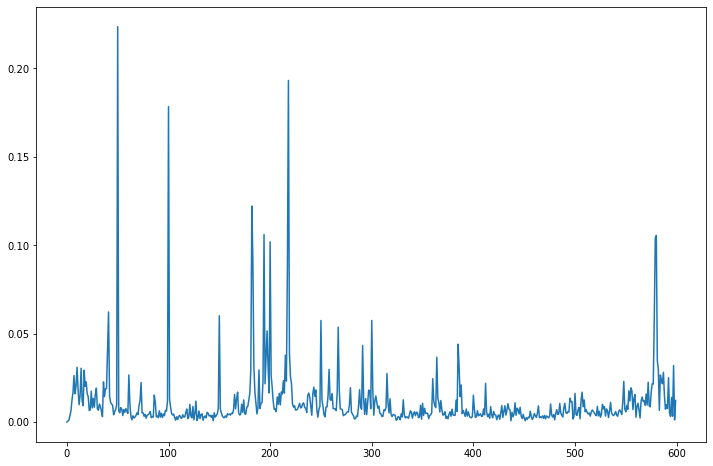

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X_train_prepared[0])

### Training

In [ ]:
#X_train_prepared = np.reshape(X_train_prepared, (X_train_prepared.shape[0], X_train_prepared.shape[1], 1))


In [ ]:
def basicModel(X_train):
  kernel_size = 10
  filter_size = 32

  model = models.Sequential()
  model.add(layers.Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  #model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(n_classes, activation = 'softmax'))
  return model

In [ ]:
model = basicModel(X_train_prepared)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 591, 32)           352       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 295, 32)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 286, 32)           10272     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 143, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 134, 32)           10272     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 67, 32)          

In [ ]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
best_model_filepath = f"{model_path}/cnn_base_line_oas.h5"
checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')

In [ ]:
n_epochs = 20
history = model.fit(X_train_prepared, y_train, epochs = n_epochs, batch_size = 64,
                   validation_split=0.33, callbacks=[checkpoint],
                    class_weight=class_weights_dict)

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.7474
Epoch 1: val_accuracy improved from -inf to 0.92470, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_oas.h5
29/29 [==============================] - 5s 146ms/step - loss: 0.7305 - accuracy: 0.7474 - val_loss: 0.2822 - val_accuracy: 0.9247
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.2054 - accuracy: 0.9269
Epoch 2: val_accuracy improved from 0.92470 to 0.97785, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_oas.h5
29/29 [==============================] - 4s 126ms/step - loss: 0.2054 - accuracy: 0.9269 - val_loss: 0.0931 - val_accuracy: 0.9779
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9673
Epoch 3: val_accuracy improved from 0.97785 to 0.98782, saving model to /content/drive/MyDrive/

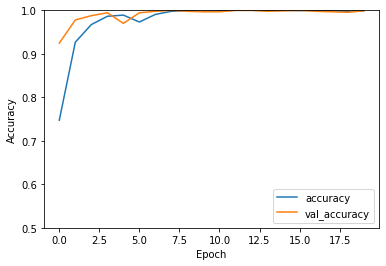

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### evaluation

In [ ]:
window = X_test.shape[1] 

X_test_prepared = np.zeros([len(X_test), int(window/2)])
for k in range(len(X_test)):
  freqs, oas, fullspec, freqsfullspec = orbitAmplitudeEspectrum(X_test[k], X2_test[k], window, fs)
  X_test_prepared[k] = oas

X_test_prepared = X_test_prepared[:, 0:600] # reducing to max 600Hz

#X_test_prepared = scaler.transform(X_test_prepared)
X_test_prepared = X_test_prepared * 10000


In [ ]:
best_model = load_model(best_model_filepath)
best_model.evaluate(X_test_prepared, y_test)

22/22 [==============================] - 1s 17ms/step - loss: 0.0038 - accuracy: 1.0000


[0.0038385922089219093, 1.0]

In [ ]:
y_pred = best_model.predict(X_test_prepared)


22/22 [==============================] - 0s 16ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_matrix(y_test, y_pred_classes)



array([[118,   0,   0],
       [  0, 323,   0],
       [  0,   0, 243]])

In [ ]:

prec = precision_score(y_test, y_pred_classes, average='macro' )
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Precision: {prec}') 
print(f'Recall: {recall}') 
print(f'F1-score: {f1}')

Precision: 1.0
Recall: 1.0
F1-score: 1.0


# Classification of 8 classes - umbalance and misaligment levels

## CNN with spec

### Preprocessing

In [ ]:
len(data_names)

27

In [ ]:
data_names

['0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalance_1751mg.mat',
 '4Nm_Unbalance_2239mg.mat',
 '4Nm_Unbalance_3318mg.mat']

In [ ]:
labels = []
labels_dic = {'Normal.mat': 0, 
              'Unbalance_0583mg': 1, 
              'Unbalance_1169mg': 2, 
              'Unbalance_1751mg': 3, 
              'Unbalance_2239mg': 4, 
              'Unbalance_3318mg': 5, 
              'Misalign_01': 6, 
              'Misalign_03': 7, 
              'Misalign_05': 8 }

for name in data_names:
  tokens = name.split('_')
  if(tokens[1]=='Unbalalnce'):
        tokens[1]='Unbalance'
  if(len(tokens)>2):
    token = tokens[1] + "_" + tokens[2].split('.')[0] 
  else:
    token = tokens[1]
  #print(tokens[1])
  print(token)
  labels.append(labels_dic.get(token, "No info available"))

print(f'Labels: {labels}')
print(len(labels))
  

Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
Labels: [6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5]
27


In [ ]:
fs

4096

In [ ]:
len(data)

27

In [ ]:
sensor = 'channel_1'
#samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


def get_features_fft(data, label):
    starting_index = fs
    data = data[starting_index: ]
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))

    X = np.abs(np.fft.rfft(X))
    X[:,0]=0
    X = X * 2
    X=X[:,0:600] # reducing to max 600Hz
    
    y = np.ones(n)*label
    return X, y




In [ ]:
data[0][sensor].shape[0] - data[0][sensor].iloc[fs:].shape[0]

4096

In [ ]:
X0,y0 = get_features_fft(data[0][sensor], labels[0])
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features_fft(data[i][sensor], labels[i])
  X0=np.concatenate([X0, X1])
  y0=np.concatenate([y0, y1])

X = X0
y = y0

print(X.shape, y.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
(3393, 600) (3393,)


In [ ]:
print(X.shape, y.shape)

(3393, 600) (3393,)


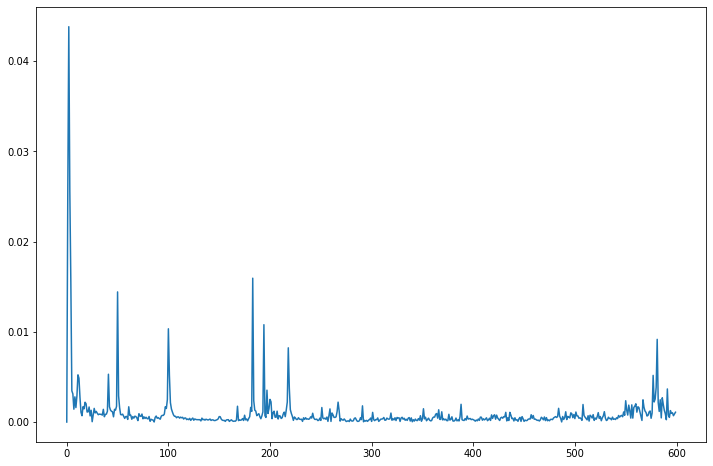

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X[0])

### Split

In [ ]:
train_test_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_test_ratio, random_state = 42)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)


(3393, 600) (3393,)
(2714, 600) (2714,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape, y_train.shape)

(2714, 600, 1) (2714,)


In [ ]:
len(y[y==0])/len(y)

0.15826702033598586

In [ ]:
len(y_train[y_train==0])/len(y_train)

0.15585851142225499

### CNN  basic

In [ ]:
n_classes = 9

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)

In [ ]:
class_weights

array([0.71289729, 1.04344483, 1.05071622, 1.00518519, 1.05071622,
       1.06934594, 1.02569917, 1.10056772, 1.08473221])

In [ ]:
data_names

['0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalance_1751mg.mat',
 '4Nm_Unbalance_2239mg.mat',
 '4Nm_Unbalance_3318mg.mat']

In [ ]:
i=4
print(data_names[i])
data[i].shape

0Nm_Unbalance_0583mg.mat


(491520, 4)

In [ ]:
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
class_weights_dict

{0: 0.7128972944575781,
 1: 1.043444828911957,
 2: 1.0507162214479289,
 3: 1.0051851851851852,
 4: 1.0507162214479289,
 5: 1.0693459416863673,
 6: 1.0256991685563115,
 7: 1.1005677210056772,
 8: 1.084732214228617}

In [ ]:
kernel_size = 10
filter_size = 32

model = models.Sequential()
model.add(layers.Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(n_classes, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 591, 32)           352       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 295, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 286, 32)           10272     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 143, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 134, 32)           10272     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 67, 32)          

In [ ]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
best_model_filepath = f"{model_path}/cnn_base_line_8_classes.h5"
checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')

In [ ]:
print(X_train.shape, y_train.shape)

(2714, 600, 1) (2714,)


In [ ]:
n_epochs = 40
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_split=0.33, callbacks=[checkpoint],
                   class_weight=class_weights_dict)

Epoch 1/40
28/29 [===========================>..] - ETA: 0s - loss: 2.1862 - accuracy: 0.1350
Epoch 1: val_accuracy improved from -inf to 0.25781, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_8_classes.h5
29/29 [==============================] - 5s 150ms/step - loss: 2.1851 - accuracy: 0.1342 - val_loss: 2.0941 - val_accuracy: 0.2578
Epoch 2/40
28/29 [===========================>..] - ETA: 0s - loss: 1.5810 - accuracy: 0.3583
Epoch 2: val_accuracy improved from 0.25781 to 0.54241, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_8_classes.h5
29/29 [==============================] - 3s 114ms/step - loss: 1.5753 - accuracy: 0.3586 - val_loss: 1.1971 - val_accuracy: 0.5424
Epoch 3/40
28/29 [===========================>..] - ETA: 0s - loss: 1.0528 - accuracy: 0.5167
Epoch 3: val_accuracy did not improve from 0.54241
29/29 [=========================

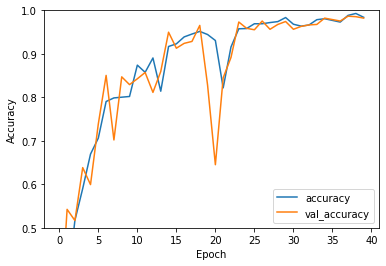

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Evaluation

In [ ]:
best_model = load_model(best_model_filepath)
best_model.evaluate(X_test, y_test)

22/22 [==============================] - 1s 15ms/step - loss: 0.0239 - accuracy: 0.9956


[0.02385832741856575, 0.9955817461013794]

In [ ]:
y_pred = best_model.predict(X_test)


22/22 [==============================] - 0s 14ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_matrix(y_test, y_pred_classes)



array([[114,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  68,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  70,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  57,   0,   0,   0,   0,   0],
       [  0,   0,   0,   2,  67,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,  75,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  63,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  83,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  79]])

In [ ]:

prec = precision_score(y_test, y_pred_classes, average='macro' )
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Precision: {prec}') 
print(f'Recall: {recall}') 
print(f'F1-score: {f1}')

Precision: 0.9947715333531568
Recall: 0.9952380952380953
F1-score: 0.9949153659904874


## Advanced CNN model 

In [ ]:
model = models.Sequential([
  layers.Conv1D(filters=32, kernel_size=10, activation='relu', input_shape=(X_train.shape[1],1)),
  layers.MaxPooling1D(pool_size=5),
  layers.Conv1D(64, 3, activation='relu'),
  #layers.Conv1D(64, 3, activation='relu'),
  layers.MaxPooling1D(pool_size=2),
  layers.Conv1D(128, 3, activation='relu'),
  #layers.Conv1D(128, 3, activation='relu'),
  layers.MaxPooling1D(pool_size=2),
  #layers.Conv1D(256, 3, activation='relu'),
  #layers.Conv1D(256, 3, activation='relu'),
  #layers.MaxPooling1D(pool_size=2),
  layers.Flatten(),
  #layers.Dense(1024, activation='relu'),
  #layers.Dropout(0.5),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1024, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(n_classes, activation = 'sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_176 (Conv1D)         (None, 591, 32)           352       
                                                                 
 max_pooling1d_129 (MaxPooli  (None, 118, 32)          0         
 ng1D)                                                           
                                                                 
 conv1d_177 (Conv1D)         (None, 116, 64)           6208      
                                                                 
 max_pooling1d_130 (MaxPooli  (None, 58, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_178 (Conv1D)         (None, 56, 128)           24704     
                                                                 
 max_pooling1d_131 (MaxPooli  (None, 28, 128)        

In [ ]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
best_model_filepath = f"{model_path}/cnn_base_line_8_classes_adv.h5"
checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')

In [ ]:
print(X_train.shape, y_train.shape)

(2736, 600, 1) (2736,)


In [ ]:
n_epochs = 20
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_split=0.33, callbacks=[checkpoint],
                   class_weight=class_weights_dict)

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 2.1970 - accuracy: 0.1277
Epoch 1: val_accuracy improved from -inf to 0.17940, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_8_classes_adv.h5
29/29 [==============================] - 6s 165ms/step - loss: 2.1970 - accuracy: 0.1277 - val_loss: 2.1850 - val_accuracy: 0.1794
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 2.1947 - accuracy: 0.1418
Epoch 2: val_accuracy did not improve from 0.17940
29/29 [==============================] - 4s 145ms/step - loss: 2.1947 - accuracy: 0.1418 - val_loss: 2.1857 - val_accuracy: 0.1794
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 2.1950 - accuracy: 0.1418
Epoch 3: val_accuracy did not improve from 0.17940
29/29 [==============================] - 4s 145ms/step - loss: 2.1950 - accuracy: 0.1418 - val_loss: 2.1848 - val_accuracy: 0.1794
Epoch 4/20
29/29 [================

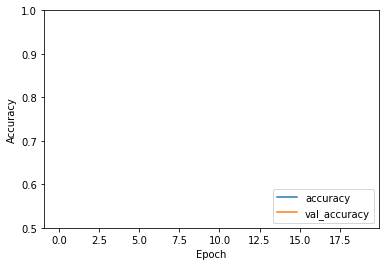

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Evaluation

In [ ]:
best_model = load_model(best_model_filepath)
best_model.evaluate(X_test, y_test)

22/22 [==============================] - 1s 22ms/step - loss: 0.0902 - accuracy: 0.9781


[0.0901615098118782, 0.9780701994895935]

In [ ]:
y_pred = best_model.predict(X_test)


22/22 [==============================] - 1s 21ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_matrix(y_test, y_pred_classes)



array([[114,   2,   0,   0,   0,   0,   2,   0,   0],
       [  0,  49,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  77,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  64,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,  68,   0,   0,   0,   0],
       [  0,   0,   0,   0,  47,  17,   0,   0,   0],
       [  8,   0,   0,   0,   0,   0,  67,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  80,   0],
       [  0,   0,   0,   0,   0,   0,   0,  88,   0]])

In [ ]:

prec = precision_score(y_test, y_pred_classes, average='macro' )
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Precision: {prec}') 
print(f'Recall: {recall}') 
print(f'F1-score: {f1}')

Precision: 0.7687039160688065
Recall: 0.7900630305139332
F1-score: 0.7396498254551113


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN with full spec

### Preprocessing with full spec

In [ ]:
len(data_names)

27

In [ ]:
data_names

['0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalance_1751mg.mat',
 '4Nm_Unbalance_2239mg.mat',
 '4Nm_Unbalance_3318mg.mat']

In [ ]:
labels = []
labels_dic = {'Normal.mat': 0, 
              'Unbalance_0583mg': 1, 
              'Unbalance_1169mg': 2, 
              'Unbalance_1751mg': 3, 
              'Unbalance_2239mg': 4, 
              'Unbalance_3318mg': 5, 
              'Misalign_01': 6, 
              'Misalign_03': 7, 
              'Misalign_05': 8 }

for name in data_names:
  tokens = name.split('_')
  if(tokens[1]=='Unbalalnce'):
        tokens[1]='Unbalance'
  if(len(tokens)>2):
    token = tokens[1] + "_" + tokens[2].split('.')[0] 
  else:
    token = tokens[1]
  #print(tokens[1])
  print(token)
  labels.append(labels_dic.get(token, "No info available"))

print(f'Labels: {labels}')
print(len(labels))
  

Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
Labels: [6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5]
27


In [ ]:
fs

4096

In [ ]:
len(data)

27

In [ ]:
#sensor = 'channel_1'
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


def get_features_full_spec(data, label):
    starting_index = fs
    data1 = df['channel_1'][starting_index:]
    n = int(np.floor(len(data1)/window))
    data1 = data1[:int(n)*window]
    data1 = data1.values.reshape((n, window))
    print(data1.shape)

    data2 = df['channel_2'][starting_index:]
    data2 = data2[:int(n)*window]
    data2 = data2.values.reshape((n, window))
    print(data2.shape)

    X = np.zeros([len(data1), int(window)]) # fullspec size
    for k in range(n):
      #orbit = np.zeros([window]).astype(complex)
      freqs, oas, fullspec = orbitAmplitudeEspectrum(data1[k], data2[k], window, fs)
      X[k] = fullspec
      #print(k)
      #data1[k] = orbit
 
    X=X[:, 0:600] # reducing to max 600Hz
    #print(X.shape)
    
    y = np.ones(n)*label
    return X, y




In [ ]:
X0,y0 = get_features_full_spec(data[0], labels[0])
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features_full_spec(data[i], labels[i])
  X0=np.concatenate([X0, X1])
  y0=np.concatenate([y0, y1])

X = X0
y = y0

print(X.shape, y.shape)

(119, 4096)
(119, 4096)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
(119, 600)
1
(119, 4096)
(119, 4096)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
(119, 600)
2
(119, 4096)
(119, 4096)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [ ]:
print(X.shape, y.shape)

(3213, 600) (3213,)


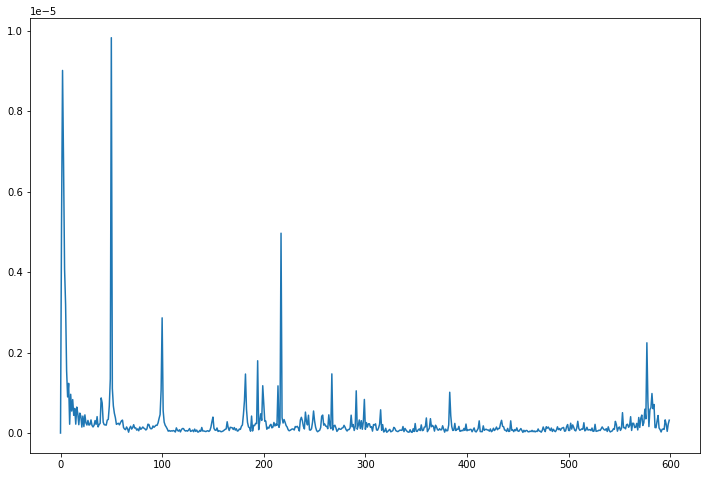

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X[0])

### Split

In [ ]:
train_test_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_test_ratio, random_state = 42)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)


(3213, 600) (3213,)
(2570, 600) (2570,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape, y_train.shape)

(2570, 600, 1) (2570,)


In [ ]:
len(y[y==0])/len(y)

0.1111111111111111

In [ ]:
len(y_train[y_train==0])/len(y_train)

0.11284046692607004

In [ ]:
len(y[y==1])/len(y)

0.1111111111111111

In [ ]:
len(y_train[y_train==1])/len(y_train)

0.10894941634241245

In [ ]:
len(y[y==2])/len(y)

0.1111111111111111

In [ ]:
len(y_train[y_train==2])/len(y_train)

0.1132295719844358

In [ ]:
len(y[y==6])/len(y)

0.1111111111111111

In [ ]:
len(y_train[y_train==6])/len(y_train)

0.11089494163424124

In [ ]:
len(y[y==7])/len(y)

0.1111111111111111

In [ ]:
len(y_train[y_train==7])/len(y_train)

0.1085603112840467

### CNN  basic

In [ ]:
n_classes = 9

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)

In [ ]:
class_weights

array([0.98467433, 1.01984127, 0.98129057, 1.00903023, 0.97459234,
       0.98808151, 1.00194932, 1.02349661, 1.01984127])

In [ ]:
data_names

['0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalance_1751mg.mat',
 '4Nm_Unbalance_2239mg.mat',
 '4Nm_Unbalance_3318mg.mat']

In [ ]:
i=4
print(data_names[i])
data[i].shape

0Nm_Unbalance_0583mg.mat


(491520, 4)

In [ ]:
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
class_weights_dict

{0: 0.9846743295019157,
 1: 1.0198412698412698,
 2: 0.9812905689194349,
 3: 1.0090302316450726,
 4: 0.9745923397800531,
 5: 0.988081507112649,
 6: 1.0019493177387915,
 7: 1.0234966148944644,
 8: 1.0198412698412698}

In [ ]:
kernel_size = 10
filter_size = 32

model = models.Sequential()
model.add(layers.Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(n_classes, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 591, 32)           352       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 295, 32)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 286, 32)           10272     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 143, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 134, 32)           10272     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 67, 32)          

In [ ]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
best_model_filepath = f"{model_path}/cnn_base_line_8_classes_full_spec.h5"
checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')

In [ ]:
print(X_train.shape, y_train.shape)

(2570, 600, 1) (2570,)


In [ ]:
n_epochs = 40
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_split=0.33, callbacks=[checkpoint],
                   class_weight=class_weights_dict)

Epoch 1/40
27/27 [==============================] - ETA: 0s - loss: 2.1998 - accuracy: 0.1139
Epoch 1: val_accuracy improved from -inf to 0.08598, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_8_classes.h5
27/27 [==============================] - 4s 119ms/step - loss: 2.1998 - accuracy: 0.1139 - val_loss: 2.1994 - val_accuracy: 0.0860
Epoch 2/40
27/27 [==============================] - ETA: 0s - loss: 2.1979 - accuracy: 0.1203
Epoch 2: val_accuracy did not improve from 0.08598
27/27 [==============================] - 3s 109ms/step - loss: 2.1979 - accuracy: 0.1203 - val_loss: 2.2014 - val_accuracy: 0.0860
Epoch 3/40
27/27 [==============================] - ETA: 0s - loss: 2.1975 - accuracy: 0.1203
Epoch 3: val_accuracy did not improve from 0.08598
27/27 [==============================] - 3s 109ms/step - loss: 2.1975 - accuracy: 0.1203 - val_loss: 2.2036 - val_accuracy: 0.0860
Epoch 4/40
27/27 [====================

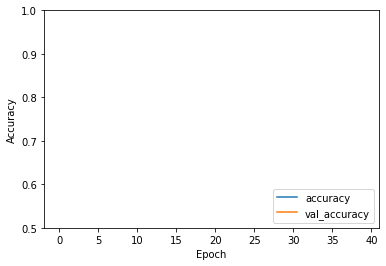

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### Evaluation

In [ ]:
best_model = load_model(best_model_filepath)
best_model.evaluate(X_test, y_test)

22/22 [==============================] - 0s 13ms/step - loss: 0.0454 - accuracy: 0.9867


[0.04536435008049011, 0.9867452383041382]

In [ ]:
y_pred = best_model.predict(X_test)


22/22 [==============================] - 0s 13ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_matrix(y_test, y_pred_classes)



array([[113,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,  68,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  70,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  56,   1,   0,   0,   0,   0],
       [  0,   0,   0,   4,  65,   1,   0,   0,   0],
       [  0,   0,   0,   0,   2,  73,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  63,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  83,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  79]])

In [ ]:

prec = precision_score(y_test, y_pred_classes, average='macro' )
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Precision: {prec}') 
print(f'Recall: {recall}') 
print(f'F1-score: {f1}')

Precision: 0.9845788243486453
Recall: 0.986176552492342
F1-score: 0.9852727953519644


## CNN with orbit amp spec

### Preprocessing 

In [ ]:
len(data_names)

27

In [ ]:
data_names

['0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalance_1751mg.mat',
 '4Nm_Unbalance_2239mg.mat',
 '4Nm_Unbalance_3318mg.mat']

In [ ]:
labels = []
labels_dic = {'Normal.mat': 0, 
              'Unbalance_0583mg': 1, 
              'Unbalance_1169mg': 2, 
              'Unbalance_1751mg': 3, 
              'Unbalance_2239mg': 4, 
              'Unbalance_3318mg': 5, 
              'Misalign_01': 6, 
              'Misalign_03': 7, 
              'Misalign_05': 8 }

for name in data_names:
  tokens = name.split('_')
  if(tokens[1]=='Unbalalnce'):
        tokens[1]='Unbalance'
  if(len(tokens)>2):
    token = tokens[1] + "_" + tokens[2].split('.')[0] 
  else:
    token = tokens[1]
  #print(tokens[1])
  print(token)
  labels.append(labels_dic.get(token, "No info available"))

print(f'Labels: {labels}')
print(len(labels))
  

Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
Labels: [6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5]
27


In [ ]:
fs

4096

In [ ]:
len(data)

27

In [ ]:
#sensor = 'channel_1'
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


def get_features_oas(data, label):
    starting_index = fs
    data1 = df['channel_1'][starting_index:]
    n = int(np.floor(len(data1)/window))
    data1 = data1[:int(n)*window]
    data1 = data1.values.reshape((n, window))
    print(data1.shape)

    data2 = df['channel_2'][starting_index:]
    data2 = data2[:int(n)*window]
    data2 = data2.values.reshape((n, window))
    print(data2.shape)

    X = np.zeros([len(data1), int(window/2)])
    for k in range(n):
      #orbit = np.zeros([window]).astype(complex)
      freqs, oas, fullspec = orbitAmplitudeEspectrum(data1[k], data2[k], window, fs)
      X[k] = oas
      #print(k)
      #data1[k] = orbit
 
    X=X[:, 0:600] # reducing to max 600Hz
    #print(X.shape)
    
    y = np.ones(n)*label
    return X, y




In [ ]:
X0,y0 = get_features_oas(data[0], labels[0])
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features_full_spec(data[i], labels[i])
  X0=np.concatenate([X0, X1])
  y0=np.concatenate([y0, y1])

X = X0
y = y0

print(X.shape, y.shape)

(119, 4096)
(119, 4096)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
(119, 600)
1
(119, 4096)
(119, 4096)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
(119, 600)
2
(119, 4096)
(119, 4096)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [ ]:
print(X.shape, y.shape)

(3213, 600) (3213,)


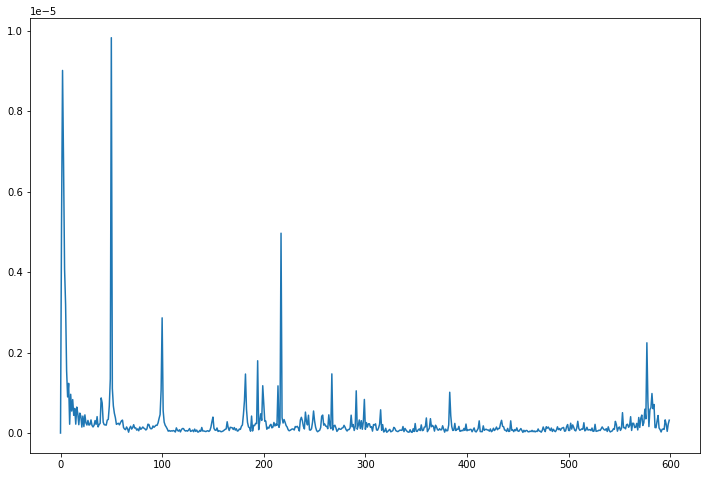

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X[0])

### Split

In [ ]:
train_test_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-train_test_ratio, random_state = 42)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)


(3213, 600) (3213,)
(2570, 600) (2570,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape, y_train.shape)

(2570, 600, 1) (2570,)


# Classification of umbalance, misaligment and bearing faults

## Loading

In [ ]:
fs=25600
new_fs = 4096
def mat_dataset_to_df(mat):
  datadf = [item.flat[0] for item in mat['Signal'][0][0]['y_values']['values']]
  a = datadf[0][:,0]
  #print(len(a))
  b = datadf[0][:,1]
  c = datadf[0][:,2]
  d = datadf[0][:,3]
  secs = len(a)/fs # Number of seconds in signal X
  samps = int(secs * new_fs)     # Number of samples to downsample
  a = scipy.signal.resample(a, samps)
  #print(len(a))
  b = scipy.signal.resample(b, samps)
  c = scipy.signal.resample(c, samps)
  d = scipy.signal.resample(d, samps)

  #a = acc_to_vel(a, new_fs)
  #b = acc_to_vel(b, new_fs)
  #c = acc_to_vel(c, new_fs)
  #d = acc_to_vel(d, new_fs)

  #print(len(datadf))
  columns = ['channel_1', 'channel_2', 'channel_3', 'channel_4' ]
  df = pd.DataFrame(list(zip(a, b, c, d)), columns=columns)  
  df.reset_index(inplace=True, drop=True)
  df.loc[:, 'channel_1']=acc_to_vel(df['channel_1'].values, new_fs)
  df.loc[:, 'channel_2']=acc_to_vel(df['channel_2'].values, new_fs)
  df.loc[:, 'channel_3']=acc_to_vel(df['channel_3'].values, new_fs)
  df.loc[:, 'channel_4']=acc_to_vel(df['channel_4'].values, new_fs)
  return df


data = []
data_names = []
with zipfile.ZipFile(url, 'r') as f:
  for i in range(len(files)):
    tokens = files[i].split('_')
    print(files[i])
    with f.open(files[i], 'r') as c:
        mat = scipy.io.loadmat(c)
        df = mat_dataset_to_df(mat)
        data.append(df)
        data_names.append(files[i])

0Nm_BPFI_03.mat
0Nm_BPFI_10.mat
0Nm_BPFI_30.mat
0Nm_BPFO_03.mat
0Nm_BPFO_10.mat
0Nm_BPFO_30.mat
0Nm_Misalign_01.mat
0Nm_Misalign_03.mat
0Nm_Misalign_05.mat
0Nm_Normal.mat
0Nm_Unbalance_0583mg.mat
0Nm_Unbalance_1169mg.mat
0Nm_Unbalance_1751mg.mat
0Nm_Unbalance_2239mg.mat
0Nm_Unbalance_3318mg.mat
2Nm_BPFI_03.mat
2Nm_BPFI_10.mat
2Nm_BPFI_30.mat
2Nm_BPFO_03.mat
2Nm_BPFO_10.mat
2Nm_BPFO_30.mat
2Nm_Misalign_01.mat
2Nm_Misalign_03.mat
2Nm_Misalign_05.mat
2Nm_Normal.mat
2Nm_Unbalalnce_0583mg.mat
2Nm_Unbalalnce_1169mg.mat
2Nm_Unbalalnce_1751mg.mat
2Nm_Unbalalnce_2239mg.mat
2Nm_Unbalalnce_3318mg.mat
4Nm_BPFI_03.mat
4Nm_BPFI_10.mat
4Nm_BPFI_30.mat
4Nm_BPFO_03.mat
4Nm_BPFO_10.mat
4Nm_BPFO_30.mat
4Nm_Misalign_01.mat
4Nm_Misalign_03.mat
4Nm_Misalign_05.mat
4Nm_Normal.mat
4Nm_Unbalance_0583mg.mat
4Nm_Unbalance_1169mg.mat
4Nm_Unbalance_1751mg.mat
4Nm_Unbalance_2239mg.mat
4Nm_Unbalance_3318mg.mat


In [ ]:
fs=new_fs
speed = 3010 #rpm
amostras_por_rotacao = 1 / (speed / 60) * fs

In [ ]:
experiment = 0

In [ ]:
data_names[experiment]

'0Nm_BPFI_03.mat'

In [ ]:
data[experiment]

,channel_1,channel_2,channel_3,channel_4
0,0.000135,0.000045,1.060265e-05,-6.644647e-05
1,-0.000355,0.000706,-5.057436e-05,1.199219e-05
2,-0.000365,0.000453,-5.450786e-07,-4.498358e-05
3,-0.000115,0.000286,8.273540e-05,-1.416822e-04
4,-0.000142,0.000642,-2.398845e-06,-3.416102e-05
...,...,...,...,...
245755,-0.000058,0.000021,2.676509e-04,1.370458e-05
245756,-0.000102,0.000316,2.717795e-04,2.020595e-04
245757,-0.000445,0.000297,2.661365e-04,2.173504e-04
245758,-0.000248,0.000074,2.411315e-04,-2.050478e-08


## EDA

0Nm_BPFI_03.mat
0.0001


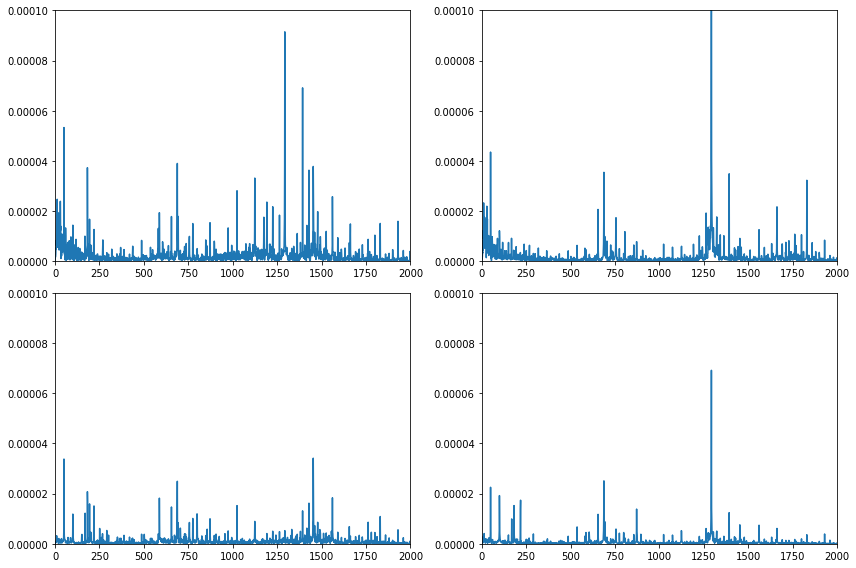

In [ ]:
experiment = 0
plot_channels_spectra(experiment, 0.0001, 2000)

0Nm_Misalign_01.mat
0.0001


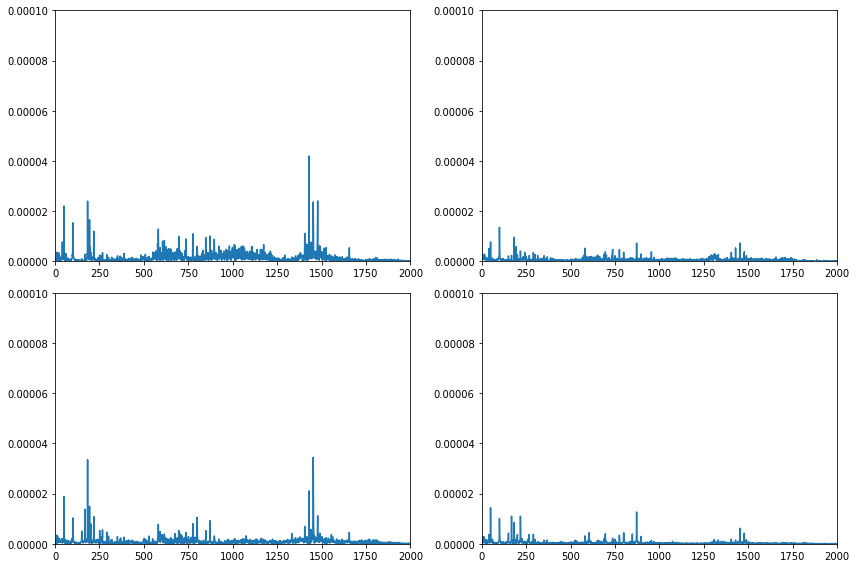

In [ ]:
experiment = 6
plot_channels_spectra(experiment, 0.0001, 2000)

## Preprocessing

In [ ]:
len(data_names)

45

In [ ]:
data_names

['0Nm_BPFI_03.mat',
 '0Nm_BPFI_10.mat',
 '0Nm_BPFI_30.mat',
 '0Nm_BPFO_03.mat',
 '0Nm_BPFO_10.mat',
 '0Nm_BPFO_30.mat',
 '0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_BPFI_03.mat',
 '2Nm_BPFI_10.mat',
 '2Nm_BPFI_30.mat',
 '2Nm_BPFO_03.mat',
 '2Nm_BPFO_10.mat',
 '2Nm_BPFO_30.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_BPFI_03.mat',
 '4Nm_BPFI_10.mat',
 '4Nm_BPFI_30.mat',
 '4Nm_BPFO_03.mat',
 '4Nm_BPFO_10.mat',
 '4Nm_BPFO_30.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalanc

In [ ]:
labels = []
labels_dic = {'Misalign':2, 'Normal.mat': 0, 'Unbalance': 1, 'Unbalalnce': 1, 'BPFI': 3, 'BPFO': 4}

for name in data_names:
  tokens = name.split('_')
  print(tokens[1])
  labels.append(labels_dic.get(tokens[1], "No info available"))

print(f'Labels: {labels}')
print(len(labels))
  

BPFI
BPFI
BPFI
BPFO
BPFO
BPFO
Misalign
Misalign
Misalign
Normal.mat
Unbalance
Unbalance
Unbalance
Unbalance
Unbalance
BPFI
BPFI
BPFI
BPFO
BPFO
BPFO
Misalign
Misalign
Misalign
Normal.mat
Unbalalnce
Unbalalnce
Unbalalnce
Unbalalnce
Unbalalnce
BPFI
BPFI
BPFI
BPFO
BPFO
BPFO
Misalign
Misalign
Misalign
Normal.mat
Unbalance
Unbalance
Unbalance
Unbalance
Unbalance
Labels: [3, 3, 3, 4, 4, 4, 2, 2, 2, 0, 1, 1, 1, 1, 1, 3, 3, 3, 4, 4, 4, 2, 2, 2, 0, 1, 1, 1, 1, 1, 3, 3, 3, 4, 4, 4, 2, 2, 2, 0, 1, 1, 1, 1, 1]
45


In [ ]:
fs

4096

In [ ]:
print(labels.count(0)/len(labels))
print(labels.count(1)/len(labels))
print(labels.count(2)/len(labels))
print(labels.count(3)/len(labels))
print(labels.count(4)/len(labels))

0.06666666666666667
0.3333333333333333
0.2
0.2
0.2


In [ ]:
def get_features(data, label, window):
    #data = data[fs:] #removing samples to avoid integration anomaly
    n = int(np.floor(len(data)/window))
    #print(len(data)/window)
    #print(n)
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))

    #X = np.abs(np.fft.rfft(X))/window
    #X[:,0]=0
    #X = X * 2
    #X=X[:, 0:600] # reducing to max 600Hz
    
    y = np.ones(n)*label
    return X, y




In [ ]:
sensor = 'channel_1'
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


X0,y0 = get_features(data[0][sensor], labels[0], window)
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features(data[i][sensor], labels[i], window)
  X0=np.concatenate([X0, X1])
  y0=np.concatenate([y0, y1])

X = X0
y = y0

print(X.shape, y.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
(4500, 4096) (4500,)


In [ ]:
sensor = 'channel_2'
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


X0,y0 = get_features(data[0][sensor], labels[0], window)
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features(data[i][sensor], labels[i], window)
  X0=np.concatenate([X0, X1])

X2 = X0


print(X2.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
(4500, 4096)


In [ ]:
print(len(y[y==0])/len(y))
print(len(y[y==1])/len(y))
print(len(y[y==2])/len(y))
print(len(y[y==3])/len(y))
print(len(y[y==4])/len(y))

0.12
0.4
0.24
0.12
0.12


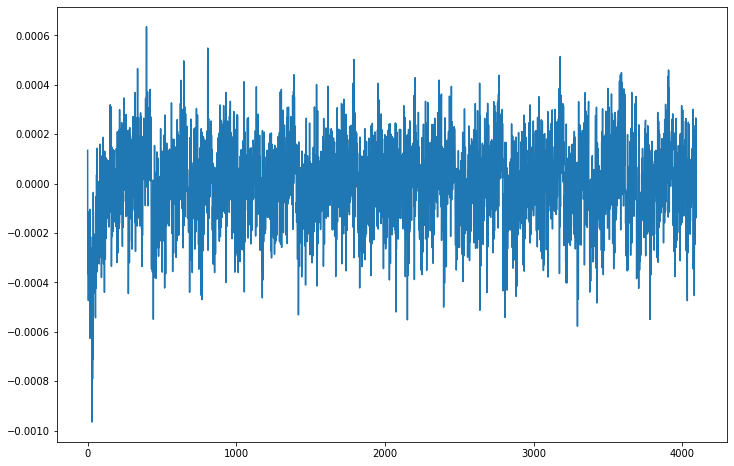

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X[0])

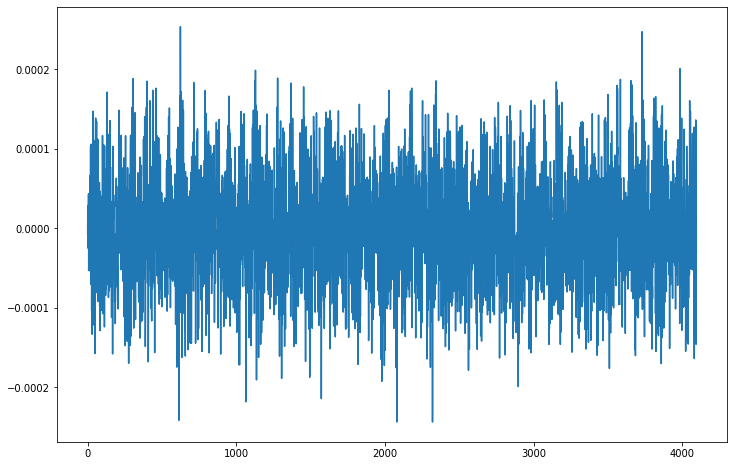

In [ ]:
fig = plt.figure(figsize=(12,8))

plt.plot(X[1000])

## Split

In [ ]:
train_test_ratio = 0.8
X_train, X_test, y_train, y_test, X2_train, X2_test = train_test_split(X, y, X2, test_size = 1-train_test_ratio, random_state = 42)

print(X.shape, y.shape, X2.shape)

print(X_train.shape, y_train.shape, X2_train.shape)


(4500, 4096) (4500,) (4500, 4096)
(3600, 4096) (3600,) (3600, 4096)


In [ ]:
n_classes = 5

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)

In [ ]:
class_weights

array([1.64383562, 0.50955414, 0.82379863, 1.62528217, 1.66666667])

In [ ]:
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
class_weights_dict

{0: 1.643835616438356,
 1: 0.5095541401273885,
 2: 0.8237986270022883,
 3: 1.6252821670428894,
 4: 1.6666666666666667}

In [ ]:
len(y[y==0])/len(y)

0.12

In [ ]:
len(y_train[y_train==0])/len(y_train)

0.12166666666666667

In [ ]:
len(y[y==1])/len(y)

0.4

In [ ]:
len(y_train[y_train==1])/len(y_train)

0.3925

In [ ]:
len(y[y==2])/len(y)

0.24

In [ ]:
len(y_train[y_train==2])/len(y_train)

0.2427777777777778

In [ ]:
len(y_train[y_train==3])/len(y_train)

0.12305555555555556

In [ ]:
len(y_train[y_train==4])/len(y_train)

0.12

## One Channel FFT

### Preprocessing

In [ ]:

window = X_train.shape[1] 
X_train_prepared = np.abs(np.fft.rfft(X_train))/window
X_train_prepared[:, 0]=0
X_train_prepared = X_train_prepared * 2
X_train_prepared = X_train_prepared[:, 0:600] # reducing to max 600Hz

#caler = MinMaxScaler()
#scaler.fit(X_train_prepared)
#X_train_scaled = scaler.transform(X_train_prepared)
#X_train_prepared = X_train_scaled

X_train_prepared = X_train_prepared * 10000




In [ ]:
data_names

['0Nm_BPFI_03.mat',
 '0Nm_BPFI_10.mat',
 '0Nm_BPFI_30.mat',
 '0Nm_BPFO_03.mat',
 '0Nm_BPFO_10.mat',
 '0Nm_BPFO_30.mat',
 '0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_BPFI_03.mat',
 '2Nm_BPFI_10.mat',
 '2Nm_BPFI_30.mat',
 '2Nm_BPFO_03.mat',
 '2Nm_BPFO_10.mat',
 '2Nm_BPFO_30.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_BPFI_03.mat',
 '4Nm_BPFI_10.mat',
 '4Nm_BPFI_30.mat',
 '4Nm_BPFO_03.mat',
 '4Nm_BPFO_10.mat',
 '4Nm_BPFO_30.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalanc

1.0


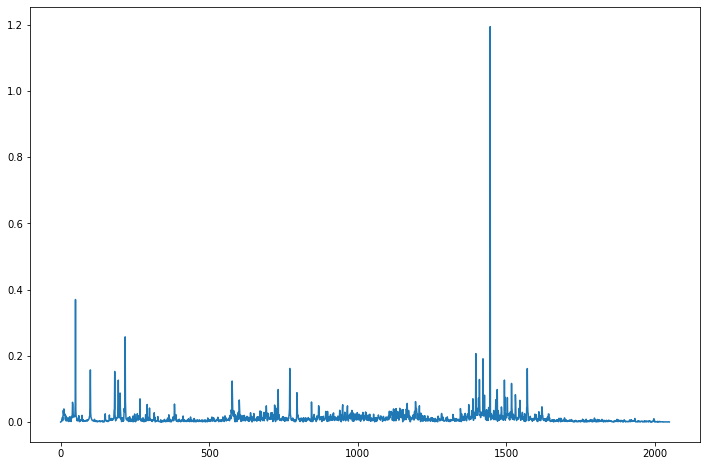

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X_train_prepared[0])
print(y_train[0])

0.0


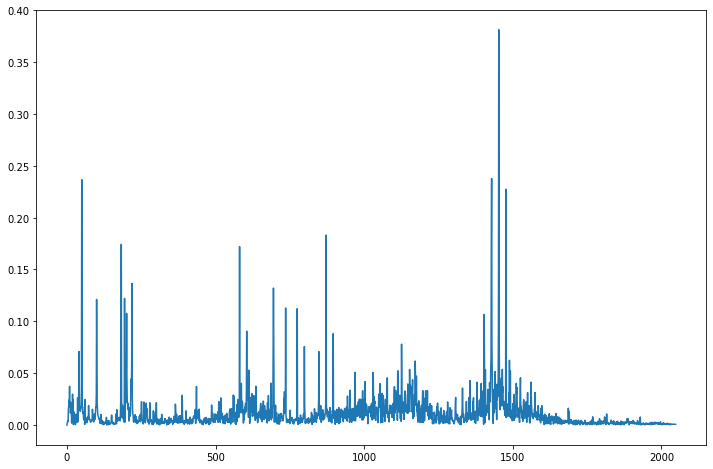

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X_train_prepared[6])
print(y_train[6])

### Training

In [ ]:

#X_train_prepared = np.reshape(X_train_prepared, (X_train_prepared.shape[0], X_train_prepared.shape[1], 1))


In [ ]:
def basicModel(X_train):
  kernel_size = 10
  filter_size = 32

  model = models.Sequential()
  model.add(layers.Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  #model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(n_classes, activation = 'softmax'))
  return model

In [ ]:
model = basicModel(X_train_prepared)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 591, 32)           352       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 295, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 286, 32)           10272     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 143, 32)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 134, 32)           10272     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 67, 32)          

In [ ]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
best_model_filepath = f"{model_path}/cnn_base_line_all_faults.h5"
checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, mode='max')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
n_epochs = 20
history = model.fit(X_train_prepared, y_train, epochs = n_epochs, batch_size = 64,
                   validation_split=0.33, callbacks=[checkpoint, earlystop],
                    class_weight=class_weights_dict)

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.8179 - accuracy: 0.6221
Epoch 1: val_accuracy improved from -inf to 0.87384, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_all_faults.h5
38/38 [==============================] - 4s 95ms/step - loss: 0.8179 - accuracy: 0.6221 - val_loss: 0.2574 - val_accuracy: 0.8738
Epoch 2/20
37/38 [============================>.] - ETA: 0s - loss: 0.2315 - accuracy: 0.8995
Epoch 2: val_accuracy improved from 0.87384 to 0.90412, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_all_faults.h5
38/38 [==============================] - 3s 79ms/step - loss: 0.2304 - accuracy: 0.9005 - val_loss: 0.2054 - val_accuracy: 0.9041
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9407
Epoch 3: val_accuracy improved from 0.90412 to 0.93776, saving model to /content/dr

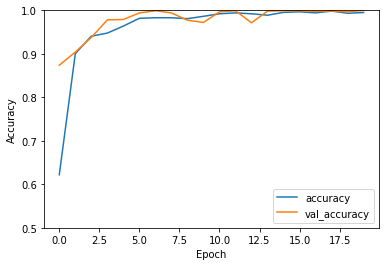

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

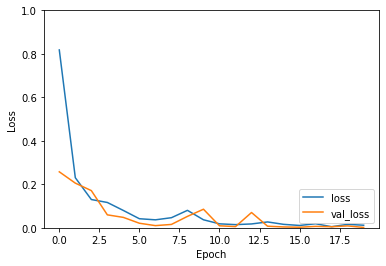

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

### evaluation

In [ ]:
X_test_prepared = np.abs(np.fft.rfft(X_test))/window
X_test_prepared[:, 0]=0
X_test_prepared = X_test_prepared * 2
X_test_prepared = X_test_prepared[:, 0:600] # reducing to max 600Hz

#X_test_prepared = scaler.transform(X_test_prepared)

X_test_prepared = X_test_prepared * 10000


#X_test_prepared = np.reshape(X_test_prepared, (X_test_prepared.shape[0], X_test_prepared.shape[1], 1))

In [ ]:
best_model = load_model(best_model_filepath)
best_model.evaluate(X_test_prepared, y_test)

29/29 [==============================] - 1s 22ms/step - loss: 0.0023 - accuracy: 1.0000


[0.0023421719670295715, 1.0]

In [ ]:
y_pred = best_model.predict(X_test_prepared)


29/29 [==============================] - 1s 20ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_matrix(y_test, y_pred_classes)



array([[102,   0,   0,   0,   0],
       [  0, 387,   0,   0,   0],
       [  0,   0, 206,   0,   0],
       [  0,   0,   0,  97,   0],
       [  0,   0,   0,   0, 108]])

In [ ]:

prec = precision_score(y_test, y_pred_classes, average='macro' )
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Precision: {prec}') 
print(f'Recall: {recall}') 
print(f'F1-score: {f1}')

Precision: 1.0
Recall: 1.0
F1-score: 1.0


# Classification of umbalance, misaligment and bearing faults and levels of faults

## Loading, dowmsampling, converting acc to vel

In [ ]:
fs=25600
new_fs = 4096
def mat_dataset_to_df(mat):
  datadf = [item.flat[0] for item in mat['Signal'][0][0]['y_values']['values']]
  a = datadf[0][:,0]
  #print(len(a))
  b = datadf[0][:,1]
  c = datadf[0][:,2]
  d = datadf[0][:,3]
  secs = len(a)/fs # Number of seconds in signal X
  samps = int(secs * new_fs)     # Number of samples to downsample
  a = scipy.signal.resample(a, samps)
  #print(len(a))
  b = scipy.signal.resample(b, samps)
  c = scipy.signal.resample(c, samps)
  d = scipy.signal.resample(d, samps)

  #print(len(datadf))
  columns = ['channel_1', 'channel_2', 'channel_3', 'channel_4' ]
  df = pd.DataFrame(list(zip(a, b, c, d)), columns=columns)  
  df.reset_index(inplace=True, drop=True)
  df.loc[:, 'channel_1']=acc_to_vel(df['channel_1'].values, new_fs)
  df.loc[:, 'channel_2']=acc_to_vel(df['channel_2'].values, new_fs)
  df.loc[:, 'channel_3']=acc_to_vel(df['channel_3'].values, new_fs)
  df.loc[:, 'channel_4']=acc_to_vel(df['channel_4'].values, new_fs)
  return df


data = []
data_names = []
with zipfile.ZipFile(url, 'r') as f:
  for i in range(len(files)):
    tokens = files[i].split('_')
    print(files[i])
    with f.open(files[i], 'r') as c:
        mat = scipy.io.loadmat(c)
        df = mat_dataset_to_df(mat)
        data.append(df)
        data_names.append(files[i])

0Nm_BPFI_03.mat
0Nm_BPFI_10.mat
0Nm_BPFI_30.mat
0Nm_BPFO_03.mat
0Nm_BPFO_10.mat
0Nm_BPFO_30.mat
0Nm_Misalign_01.mat
0Nm_Misalign_03.mat
0Nm_Misalign_05.mat
0Nm_Normal.mat
0Nm_Unbalance_0583mg.mat
0Nm_Unbalance_1169mg.mat
0Nm_Unbalance_1751mg.mat
0Nm_Unbalance_2239mg.mat
0Nm_Unbalance_3318mg.mat
2Nm_BPFI_03.mat
2Nm_BPFI_10.mat
2Nm_BPFI_30.mat
2Nm_BPFO_03.mat
2Nm_BPFO_10.mat
2Nm_BPFO_30.mat
2Nm_Misalign_01.mat
2Nm_Misalign_03.mat
2Nm_Misalign_05.mat
2Nm_Normal.mat
2Nm_Unbalalnce_0583mg.mat
2Nm_Unbalalnce_1169mg.mat
2Nm_Unbalalnce_1751mg.mat
2Nm_Unbalalnce_2239mg.mat
2Nm_Unbalalnce_3318mg.mat
4Nm_BPFI_03.mat
4Nm_BPFI_10.mat
4Nm_BPFI_30.mat
4Nm_BPFO_03.mat
4Nm_BPFO_10.mat
4Nm_BPFO_30.mat
4Nm_Misalign_01.mat
4Nm_Misalign_03.mat
4Nm_Misalign_05.mat
4Nm_Normal.mat
4Nm_Unbalance_0583mg.mat
4Nm_Unbalance_1169mg.mat
4Nm_Unbalance_1751mg.mat
4Nm_Unbalance_2239mg.mat
4Nm_Unbalance_3318mg.mat


In [ ]:
fs=new_fs
speed = 3010 #rpm
amostras_por_rotacao = 1 / (speed / 60) * fs

In [ ]:
experiment = 0

In [ ]:
data_names[experiment]

'0Nm_BPFI_03.mat'

In [ ]:
data[experiment]

,channel_1,channel_2,channel_3,channel_4
0,0.000135,0.000045,1.060265e-05,-6.644647e-05
1,-0.000355,0.000706,-5.057436e-05,1.199219e-05
2,-0.000365,0.000453,-5.450786e-07,-4.498358e-05
3,-0.000115,0.000286,8.273540e-05,-1.416822e-04
4,-0.000142,0.000642,-2.398845e-06,-3.416102e-05
...,...,...,...,...
245755,-0.000058,0.000021,2.676509e-04,1.370458e-05
245756,-0.000102,0.000316,2.717795e-04,2.020595e-04
245757,-0.000445,0.000297,2.661365e-04,2.173504e-04
245758,-0.000248,0.000074,2.411315e-04,-2.050478e-08


## Preprocessing

In [ ]:
len(data_names)

45

In [ ]:
data_names

['0Nm_BPFI_03.mat',
 '0Nm_BPFI_10.mat',
 '0Nm_BPFI_30.mat',
 '0Nm_BPFO_03.mat',
 '0Nm_BPFO_10.mat',
 '0Nm_BPFO_30.mat',
 '0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_BPFI_03.mat',
 '2Nm_BPFI_10.mat',
 '2Nm_BPFI_30.mat',
 '2Nm_BPFO_03.mat',
 '2Nm_BPFO_10.mat',
 '2Nm_BPFO_30.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_BPFI_03.mat',
 '4Nm_BPFI_10.mat',
 '4Nm_BPFI_30.mat',
 '4Nm_BPFO_03.mat',
 '4Nm_BPFO_10.mat',
 '4Nm_BPFO_30.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalanc

In [ ]:
labels = []
labels_dic = {'Normal.mat': 0, 
              'Unbalance_0583mg': 1, 
              'Unbalance_1169mg': 2, 
              'Unbalance_1751mg': 3, 
              'Unbalance_2239mg': 4, 
              'Unbalance_3318mg': 5, 
              'Misalign_01': 6, 
              'Misalign_03': 7, 
              'Misalign_05': 8,
              'BPFI_03': 9,
              'BPFI_10': 10,
              'BPFI_30': 11,
              'BPFO_03': 12,
              'BPFO_10': 13,
              'BPFO_30': 14}

for name in data_names:
  tokens = name.split('_')
  if(tokens[1]=='Unbalalnce'):
        tokens[1]='Unbalance'
  if(len(tokens)>2):
    token = tokens[1] + "_" + tokens[2].split('.')[0] 
  else:
    token = tokens[1]
  #print(tokens[1])
  print(token)
  labels.append(labels_dic.get(token, "No info available"))

print(f'Labels: {labels}')
print(len(labels))

BPFI_03
BPFI_10
BPFI_30
BPFO_03
BPFO_10
BPFO_30
Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
BPFI_03
BPFI_10
BPFI_30
BPFO_03
BPFO_10
BPFO_30
Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
BPFI_03
BPFI_10
BPFI_30
BPFO_03
BPFO_10
BPFO_30
Misalign_01
Misalign_03
Misalign_05
Normal.mat
Unbalance_0583mg
Unbalance_1169mg
Unbalance_1751mg
Unbalance_2239mg
Unbalance_3318mg
Labels: [9, 10, 11, 12, 13, 14, 6, 7, 8, 0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 6, 7, 8, 0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14, 6, 7, 8, 0, 1, 2, 3, 4, 5]
45


In [ ]:
fs

4096

In [ ]:
for i in range(len(labels_dic)):
  print(labels.count(i)/len(labels))
  

0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667


In [ ]:
def get_features(data, label, window):
    #data = data[fs:] #removing samples to avoid integration anomaly
    n = int(np.floor(len(data)/window))
    #print(len(data)/window)
    #print(n)
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))

    #X = np.abs(np.fft.rfft(X))/window
    #X[:,0]=0
    #X = X * 2
    #X=X[:, 0:600] # reducing to max 600Hz
    
    y = np.ones(n)*label
    return X, y




In [ ]:
sensor = 'channel_1'
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


X0,y0 = get_features(data[0][sensor], labels[0], window)
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features(data[i][sensor], labels[i], window)
  X0=np.concatenate([X0, X1])
  y0=np.concatenate([y0, y1])

X = X0
y = y0

print(X.shape, y.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
(4500, 4096) (4500,)


In [ ]:
sensor = 'channel_2'
seconds_per_analysis = 1.0
window = int(fs * seconds_per_analysis)


X0,y0 = get_features(data[0][sensor], labels[0], window)
for i in range(1, len(data)):
  print(i)
  X1,y1 = get_features(data[i][sensor], labels[i], window)
  X0=np.concatenate([X0, X1])

X2 = X0


print(X2.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
(4500, 4096)


In [ ]:
for i in range(len(labels_dic)):
  print(len(y[y==i])/len(y))


0.12
0.08
0.08
0.08
0.08
0.08
0.08
0.08
0.08
0.04
0.04
0.04
0.04
0.04
0.04


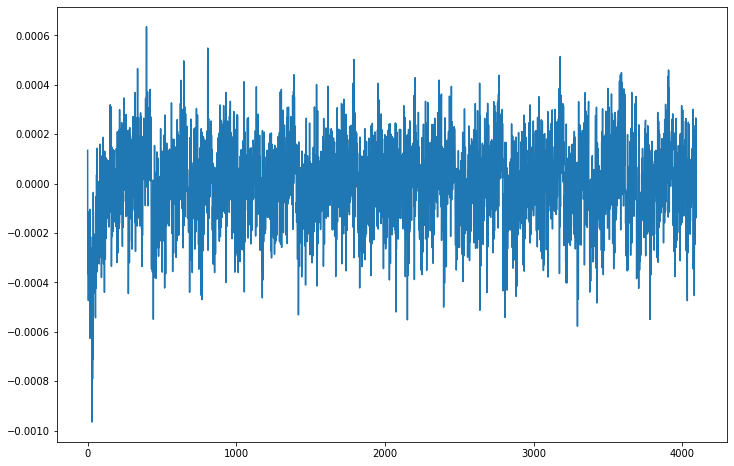

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X[0])

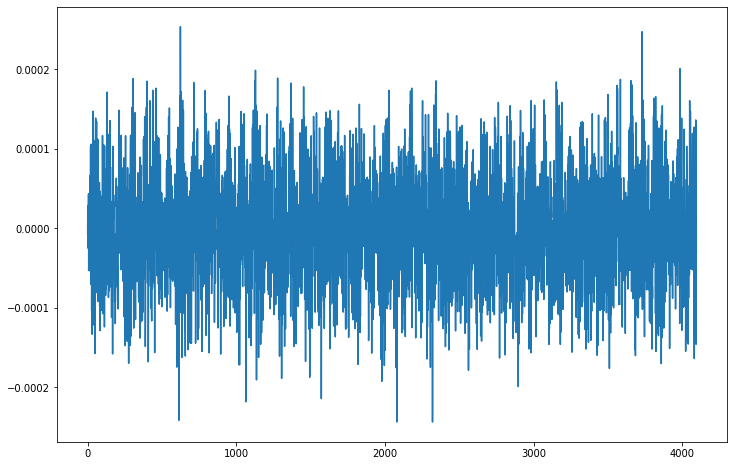

In [ ]:
fig = plt.figure(figsize=(12,8))

plt.plot(X[1000])

## Split

In [ ]:
train_test_ratio = 0.8
X_train, X_test, y_train, y_test, X2_train, X2_test = train_test_split(X, y, X2, test_size = 1-train_test_ratio, random_state = 42)

print(X.shape, y.shape, X2.shape)

print(X_train.shape, y_train.shape, X2_train.shape)


(4500, 4096) (4500,) (4500, 4096)
(3600, 4096) (3600,) (3600, 4096)


In [ ]:
n_classes = len(labels_dic)

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)

In [ ]:
class_weights

array([0.54794521, 0.84805654, 0.87912088, 0.84805654, 0.81911263,
       0.85409253, 0.80267559, 0.85106383, 0.81911263, 1.57894737,
       1.63265306, 1.66666667, 1.69014085, 1.65517241, 1.65517241])

In [ ]:
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
class_weights_dict

{0: 0.547945205479452,
 1: 0.8480565371024735,
 2: 0.8791208791208791,
 3: 0.8480565371024735,
 4: 0.8191126279863481,
 5: 0.8540925266903915,
 6: 0.802675585284281,
 7: 0.851063829787234,
 8: 0.8191126279863481,
 9: 1.5789473684210527,
 10: 1.6326530612244898,
 11: 1.6666666666666667,
 12: 1.6901408450704225,
 13: 1.6551724137931034,
 14: 1.6551724137931034}

## One Channel FFT

### Preprocessing

In [ ]:

window = X_train.shape[1] 
X_train_prepared = np.abs(np.fft.rfft(X_train))/window
X_train_prepared[:, 0]=0
X_train_prepared = X_train_prepared * 2
#X_train_prepared = X_train_prepared[:, 0:600] # reducing to max 600Hz

#caler = MinMaxScaler()
#scaler.fit(X_train_prepared)
#X_train_scaled = scaler.transform(X_train_prepared)
#X_train_prepared = X_train_scaled

X_train_prepared = X_train_prepared * 10000




In [ ]:
data_names

['0Nm_BPFI_03.mat',
 '0Nm_BPFI_10.mat',
 '0Nm_BPFI_30.mat',
 '0Nm_BPFO_03.mat',
 '0Nm_BPFO_10.mat',
 '0Nm_BPFO_30.mat',
 '0Nm_Misalign_01.mat',
 '0Nm_Misalign_03.mat',
 '0Nm_Misalign_05.mat',
 '0Nm_Normal.mat',
 '0Nm_Unbalance_0583mg.mat',
 '0Nm_Unbalance_1169mg.mat',
 '0Nm_Unbalance_1751mg.mat',
 '0Nm_Unbalance_2239mg.mat',
 '0Nm_Unbalance_3318mg.mat',
 '2Nm_BPFI_03.mat',
 '2Nm_BPFI_10.mat',
 '2Nm_BPFI_30.mat',
 '2Nm_BPFO_03.mat',
 '2Nm_BPFO_10.mat',
 '2Nm_BPFO_30.mat',
 '2Nm_Misalign_01.mat',
 '2Nm_Misalign_03.mat',
 '2Nm_Misalign_05.mat',
 '2Nm_Normal.mat',
 '2Nm_Unbalalnce_0583mg.mat',
 '2Nm_Unbalalnce_1169mg.mat',
 '2Nm_Unbalalnce_1751mg.mat',
 '2Nm_Unbalalnce_2239mg.mat',
 '2Nm_Unbalalnce_3318mg.mat',
 '4Nm_BPFI_03.mat',
 '4Nm_BPFI_10.mat',
 '4Nm_BPFI_30.mat',
 '4Nm_BPFO_03.mat',
 '4Nm_BPFO_10.mat',
 '4Nm_BPFO_30.mat',
 '4Nm_Misalign_01.mat',
 '4Nm_Misalign_03.mat',
 '4Nm_Misalign_05.mat',
 '4Nm_Normal.mat',
 '4Nm_Unbalance_0583mg.mat',
 '4Nm_Unbalance_1169mg.mat',
 '4Nm_Unbalanc

2.0


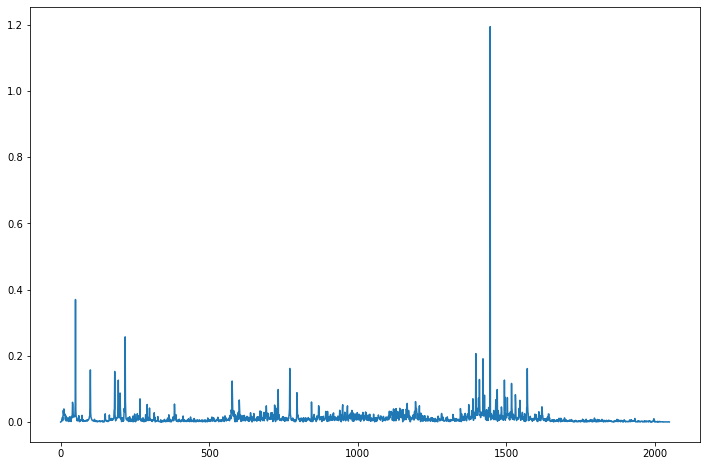

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X_train_prepared[0])
print(y_train[0])

0.0


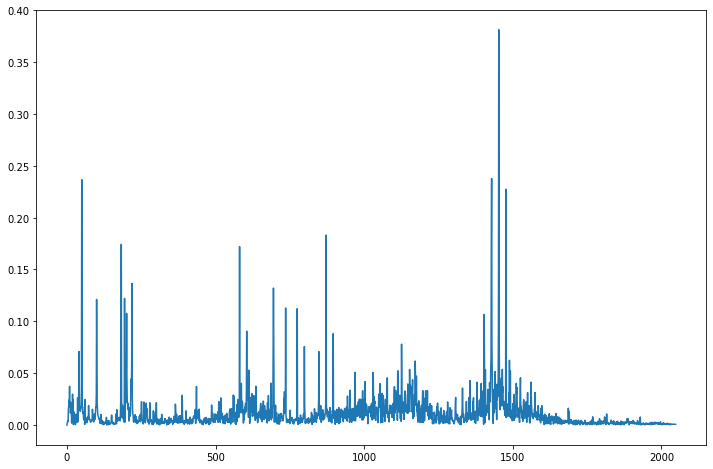

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(X_train_prepared[6])
print(y_train[6])

### Training

In [ ]:

#X_train_prepared = np.reshape(X_train_prepared, (X_train_prepared.shape[0], X_train_prepared.shape[1], 1))


In [ ]:
def basicModel(X_train):
  kernel_size = 10
  filter_size = 32

  model = models.Sequential()
  model.add(layers.Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1],1)))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.MaxPooling1D(pool_size=2))
  #model.add(layers.Conv1D(filter_size, (kernel_size), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(n_classes, activation = 'softmax'))
  return model

In [ ]:
model = basicModel(X_train_prepared)
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 2040, 32)          352       
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 1020, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 1011, 32)          10272     
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 505, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 496, 32)           10272     
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 248, 32)         

In [ ]:
model.compile(optimizer='adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
best_model_filepath = f"{model_path}/cnn_base_line_all_faults_and_levels.h5"
checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss', 
                                 verbose=1, save_best_only=True, mode='min')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
n_epochs = 20
history = model.fit(X_train_prepared, y_train, epochs = n_epochs, batch_size = 64,
                   validation_split=0.2,
                    class_weight=class_weights_dict,
                    callbacks=[checkpoint, earlystop])

Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 1.4512 - accuracy: 0.4000
Epoch 1: val_loss improved from inf to 0.88313, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_all_faults_and_levels.h5
45/45 [==============================] - 15s 311ms/step - loss: 1.4512 - accuracy: 0.4000 - val_loss: 0.8831 - val_accuracy: 0.6681
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.6962
Epoch 2: val_loss improved from 0.88313 to 0.47866, saving model to /content/drive/MyDrive/Vibration classification of rotating shaft under unbalance/models/cnn_base_line_all_faults_and_levels.h5
45/45 [==============================] - 10s 230ms/step - loss: 0.5931 - accuracy: 0.6962 - val_loss: 0.4787 - val_accuracy: 0.7778
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.4048 - accuracy: 0.7809
Epoch 3: val_loss improved from 0.47866 to 0.31300, saving model t

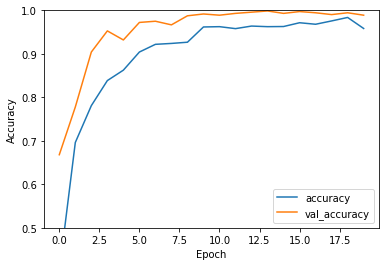

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

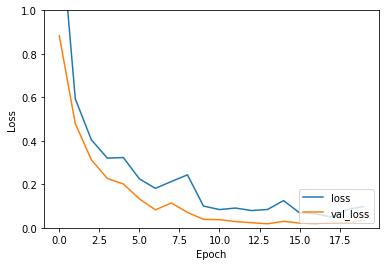

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

### evaluation

In [ ]:
X_test_prepared = np.abs(np.fft.rfft(X_test))/window
X_test_prepared[:, 0]=0
X_test_prepared = X_test_prepared * 2
#X_test_prepared = X_test_prepared[:, 0:600] # reducing to max 600Hz

#X_test_prepared = scaler.transform(X_test_prepared)

X_test_prepared = X_test_prepared * 10000


#X_test_prepared = np.reshape(X_test_prepared, (X_test_prepared.shape[0], X_test_prepared.shape[1], 1))

In [ ]:
best_model = load_model(best_model_filepath)
best_model.evaluate(X_test_prepared, y_test)

29/29 [==============================] - 1s 27ms/step - loss: 0.0213 - accuracy: 0.9978


[0.021345997229218483, 0.9977777600288391]

In [ ]:
y_pred = best_model.predict(X_test_prepared)


29/29 [==============================] - 1s 27ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_matrix(y_test, y_pred_classes)



array([[101,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,  77,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,  87,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,  76,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  67,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  79,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  61,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  78,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  67,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  28,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  33,   0,   0,
       

In [ ]:

prec = precision_score(y_test, y_pred_classes, average='macro' )
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f'Precision: {prec}') 
print(f'Recall: {recall}') 
print(f'F1-score: {f1}')

Precision: 0.9981649069884365
Recall: 0.9984806043629573
F1-score: 0.9983119282401709
